In [15]:
import sys
import os
import platform
import importlib
import glob
import pandas as pd
import numpy as np
import netCDF4
from datetime import datetime, timedelta
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.pyplot as plt
if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/subin/data'
    cpuserver_data_FP = '/Users/subin/cpuserver_data'
elif platform.system() == 'Linux':
    base_FP = '/home/subin/data'
    cpuserver_data_FP = '/home/subin/cpuserver_data'
else:
    base_FP = '/home/subin/data'
    cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')
print(base_FP, cpuserver_data_FP)

#hydroAI libs
import HydroAI.ASCAT_TUW as hASCAT_TUW
import HydroAI.Plot as hPlot
import HydroAI.Data as hData
import HydroAI.Grid as hGrid
import HydroAI.AMSR2_LPRM as hAMSR2_LPRM
import HydroAI.SMOS_CATDS as hSMOS_CATDS
import HydroAI.ERA5_land as hERA5_land
importlib.reload(hASCAT_TUW)
importlib.reload(hPlot)
importlib.reload(hData)
importlib.reload(hGrid)
importlib.reload(hAMSR2_LPRM)
importlib.reload(hSMOS_CATDS)
importlib.reload(hERA5_land)
# Ignore runtime warnings
import warnings
warnings.filterwarnings("ignore")

import Slack.slack_notifier as Slack

env_path = os.path.join('/home/subin', '.env')
notifier = Slack.Notifier(env_path)
print(env_path)

/home/subin/data /home/subin/cpuserver_data
/home/subin/.env


In [2]:
year_start = 2015
year_finish = 2023
time_list = ['am', 'pm']

with netCDF4.Dataset(f'{cpuserver_data_FP}/extracted_nc/projects/2025_KMA_050_grid/ll_coord_720x360_regular.nc', 'r') as nc:
    print(nc.variables.keys())
    domain_lat = nc.variables['lats'][:].data
    domain_lon = nc.variables['lons'][:].data
    domain_lat = np.flip(domain_lat) # For start from 90 to -90
    domain_lon -= 180  # For start from -180 to 180
    domain_lon += 0.25 # For symmetric domain

# Create 2D arrays from 1D domain_lat and domain_lon
domain_lon, domain_lat = np.meshgrid(domain_lon, domain_lat)

print(domain_lat.shape, domain_lon.shape)

dict_keys(['lons', 'lats'])
(360, 720) (360, 720)


In [3]:
# Check the domain_lat and domain_lon
print(domain_lat)
print(domain_lon)

[[ 89.75  89.75  89.75 ...  89.75  89.75  89.75]
 [ 89.25  89.25  89.25 ...  89.25  89.25  89.25]
 [ 88.75  88.75  88.75 ...  88.75  88.75  88.75]
 ...
 [-88.75 -88.75 -88.75 ... -88.75 -88.75 -88.75]
 [-89.25 -89.25 -89.25 ... -89.25 -89.25 -89.25]
 [-89.75 -89.75 -89.75 ... -89.75 -89.75 -89.75]]
[[-179.75 -179.25 -178.75 ...  178.75  179.25  179.75]
 [-179.75 -179.25 -178.75 ...  178.75  179.25  179.75]
 [-179.75 -179.25 -178.75 ...  178.75  179.25  179.75]
 ...
 [-179.75 -179.25 -178.75 ...  178.75  179.25  179.75]
 [-179.75 -179.25 -178.75 ...  178.75  179.25  179.75]
 [-179.75 -179.25 -178.75 ...  178.75  179.25  179.75]]


#### GLDAS VIC SM & ET

In [26]:
GLDAS_time_list = ['0000', '0300', '0600', '0900', '1200', '1500', '1800', '2100']

GLDAS_lon_lat_read_path = f'{cpuserver_data_FP}/GLDAS/VIC/3h_SM_ET/2015/2015.01.01/GLDAS_VIC10_3H.A20150101.0000.021.nc4.SUB.nc4'
with netCDF4.Dataset(GLDAS_lon_lat_read_path) as nc_data:
    GLDAS_VIC_lat = nc_data.variables['lat'][:].data 
    GLDAS_VIC_lon = nc_data.variables['lon'][:].data
    print(np.shape(GLDAS_VIC_lat), np.shape(GLDAS_VIC_lon))
    m, n = np.shape(GLDAS_VIC_lat)[0], np.shape(GLDAS_VIC_lon)[0]

    # Flip & For 2D
    GLDAS_VIC_lat = np.flip(GLDAS_VIC_lat)
    GLDAS_VIC_lon_2d, GLDAS_VIC_lat_2d = np.meshgrid(GLDAS_VIC_lon, GLDAS_VIC_lat)
    print(np.shape(GLDAS_VIC_lon_2d), np.shape(GLDAS_VIC_lat_2d))

for year in tqdm(range(year_start, year_finish + 1)):
    GLDAS_3h_path = f'{cpuserver_data_FP}/GLDAS/VIC/3h_SM_ET/{year}/'
    pattern = os.path.join(GLDAS_3h_path, "[0-9][0-9][0-9][0-9].[0-9][0-9].[0-9][0-9]")
    folder_list = glob.glob(pattern)
    folder_list.sort()

    yearly_SM = np.full((m, n, len(folder_list)), np.nan)
    yearly_ET = np.full((m, n, len(folder_list)), np.nan)

    for folder_idx, folder in enumerate(folder_list):
        month = str(folder.split('.')[1])
        day = str(folder.split('.')[2])

        for time_idx, time in enumerate(GLDAS_time_list):
            GLDAS_3h_file = f'{folder}/GLDAS_VIC10_3H.A{year}{month}{day}.{time}.021.nc4.SUB.nc4'
            daily_SM = np.full((m, n, 8), np.nan)
            daily_ET = np.full((m, n, 8), np.nan)

            with netCDF4.Dataset(GLDAS_3h_file) as GLDAS_3h_data:
                VIC_SM = GLDAS_3h_data.variables['SoilMoi0_30cm_inst'][:].data[0, :, :] # (time=1, lat, lon)
                VIC_Evap = GLDAS_3h_data.variables['Evap_tavg'][:].data[0, :, :]
                VIC_ECanop = GLDAS_3h_data.variables['ECanop_tavg'][:].data[0, :, :]
                VIC_ESoil = GLDAS_3h_data.variables['ESoil_tavg'][:].data[0, :, :]
                # Replace Fill value into np.nan
                VIC_SM[VIC_SM < -9990] = np.nan
                VIC_Evap[VIC_Evap < -9990] = np.nan
                VIC_ECanop[VIC_ECanop < -9990] = np.nan
                VIC_ESoil[VIC_ESoil < -9990] = np.nan

                # Sum of Evap, ECanop, ESoil
                VIC_ET = np.stack([VIC_Evap, VIC_ECanop, VIC_ESoil], axis=2)
                VIC_ET = np.sum(VIC_ET, axis=2)

                daily_SM[:, :, time_idx] = np.flipud(VIC_SM)
                daily_ET[:, :, time_idx] = np.flipud(VIC_ET)

            daily_SM = np.nanmean(daily_SM, axis=2)
            daily_ET = np.nanmean(daily_ET, axis=2)

        yearly_SM[:, :, folder_idx] = daily_SM
        yearly_ET[:, :, folder_idx] = daily_ET

    nc_file_name = f'{cpuserver_data_FP}/extracted_nc/GLDAS_VIC/GLDAS_VIC_{year}.nc'
    if os.path.exists(nc_file_name):
        os.remove(nc_file_name)
    hData.create_netcdf_file(nc_file_name, 
                             longitude=GLDAS_VIC_lon_2d,
                             latitude=GLDAS_VIC_lat_2d,
                             SoilMoi0_30cm_inst=yearly_SM,
                             ET=yearly_ET)
    print(f"NetCDF file created: {nc_file_name}")

(150,) (360,)
(150, 360) (150, 360)


 11%|█         | 1/9 [00:20<02:41, 20.23s/it]

NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2015.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2015.nc


 22%|██▏       | 2/9 [00:43<02:34, 22.12s/it]

NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2016.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2016.nc


 33%|███▎      | 3/9 [01:06<02:14, 22.41s/it]

NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2017.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2017.nc


 44%|████▍     | 4/9 [01:29<01:52, 22.59s/it]

NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2018.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2018.nc


 56%|█████▌    | 5/9 [01:52<01:31, 22.90s/it]

NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2019.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2019.nc


 67%|██████▋   | 6/9 [02:15<01:08, 22.92s/it]

NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2020.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2020.nc


 78%|███████▊  | 7/9 [02:40<00:46, 23.43s/it]

NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2021.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2021.nc


 89%|████████▉ | 8/9 [03:02<00:23, 23.19s/it]

NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2022.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2022.nc


100%|██████████| 9/9 [03:25<00:00, 22.88s/it]

NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2023.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2023.nc


In [27]:
for year in range(year_start, year_finish + 1):
    GLDAS_VIC_file = f'{cpuserver_data_FP}/extracted_nc/GLDAS_VIC/GLDAS_VIC_{year}.nc'
    with netCDF4.Dataset(GLDAS_VIC_file) as GLDAS_VIC_data:
        GLDAS_VIC_lat = GLDAS_VIC_data.variables['latitude'][:].data
        GLDAS_VIC_lon = GLDAS_VIC_data.variables['longitude'][:].data
        GLDAS_VIC_sm  = GLDAS_VIC_data.variables['SoilMoi0_30cm_inst'][:].data
        GLDAS_VIC_et  = GLDAS_VIC_data.variables['ET'][:].data

    GLDAS_VIC_R_sm  = hData.Resampling_forloop(domain_lon, domain_lat, GLDAS_VIC_lon, GLDAS_VIC_lat, GLDAS_VIC_sm, mag_factor=2)
    GLDAS_VIC_R_et  = hData.Resampling_forloop(domain_lon, domain_lat, GLDAS_VIC_lon, GLDAS_VIC_lat, GLDAS_VIC_et, mag_factor=2)
    
    nc_file_name = f'{cpuserver_data_FP}/extracted_nc/GLDAS_VIC/GLDAS_VIC_{year}_R_eqd_050.nc'
    if os.path.exists(nc_file_name):
        os.remove(nc_file_name)
    hData.create_netcdf_file(nc_file_name, 
                             longitude=domain_lon,
                             latitude=domain_lat,
                             SoilMoi0_30cm_inst=GLDAS_VIC_R_sm,
                             ET=GLDAS_VIC_R_et)
    print(f"NetCDF file created: {nc_file_name}")

  0%|          | 0/365 [00:00<?, ?it/s]

100%|██████████| 365/365 [00:05<00:00, 67.77it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2015_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2015_R_eqd_050.nc


100%|██████████| 366/366 [00:05<00:00, 69.94it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2016_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2016_R_eqd_050.nc


100%|██████████| 365/365 [00:05<00:00, 69.83it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2017_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2017_R_eqd_050.nc


100%|██████████| 365/365 [00:05<00:00, 70.25it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2018_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2018_R_eqd_050.nc


100%|██████████| 365/365 [00:05<00:00, 70.12it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2019_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2019_R_eqd_050.nc


100%|██████████| 366/366 [00:05<00:00, 70.01it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2020_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2020_R_eqd_050.nc


100%|██████████| 365/365 [00:05<00:00, 70.00it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2021_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2021_R_eqd_050.nc


100%|██████████| 365/365 [00:05<00:00, 70.11it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2022_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2022_R_eqd_050.nc


100%|██████████| 365/365 [00:05<00:00, 68.96it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2023_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_VIC/GLDAS_VIC_2023_R_eqd_050.nc


#### GLDAS Noah SM & ET

In [31]:
GLDAS_lon_lat_read_path = f'{cpuserver_data_FP}/GLDAS/Noah/daily/2015.01.01/GLDAS_NOAH025_20150101.nc'
with netCDF4.Dataset(GLDAS_lon_lat_read_path) as nc_data:
    GLDAS_Noah_lat = nc_data.variables['latitude'][:].data 
    GLDAS_Noah_lon = nc_data.variables['longitude'][:].data
    print(np.shape(GLDAS_Noah_lat), np.shape(GLDAS_Noah_lon))
    m, n = np.shape(GLDAS_Noah_lat)[0], np.shape(GLDAS_Noah_lon)[1]

for year in tqdm(range(year_start, year_finish + 1)):
    GLDAS_Noah_path = f'{cpuserver_data_FP}/GLDAS/Noah/daily/'
    pattern = os.path.join(GLDAS_Noah_path, f"{year}.[0-9][0-9].[0-9][0-9]")
    folder_list = glob.glob(pattern)
    folder_list.sort()

    yearly_SM = np.full((m, n, len(folder_list)), np.nan)
    yearly_ET = np.full((m, n, len(folder_list)), np.nan)
    
    print(year, len(folder_list))
    for folder_idx, folder in enumerate(folder_list):
        month = str(folder.split('.')[1])
        day = str(folder.split('.')[2])

        GLDAS_Noah_file = f'{folder}/GLDAS_NOAH025_{year}{month}{day}.nc'
        daily_SM = np.full((m, n, 8), np.nan)
        daily_ET = np.full((m, n, 8), np.nan)

        with netCDF4.Dataset(GLDAS_Noah_file) as GLDAS_Noah_data:
            Noah_SM = GLDAS_Noah_data.variables['SoilMoi0_10cm_inst'][:].data[:, :, 0] # (lat, lon, time=1)
            Noah_Evap = GLDAS_Noah_data.variables['Evap_tavg'][:].data[:, :, 0]
            Noah_ECanop = GLDAS_Noah_data.variables['ECanop_tavg'][:].data[:, :, 0]
            Noah_ESoil = GLDAS_Noah_data.variables['ESoil_tavg'][:].data[:, :, 0]
            # Replace Fill value into np.nan
            Noah_SM[Noah_SM < -9990] = np.nan
            Noah_Evap[Noah_Evap < -9990] = np.nan
            Noah_ECanop[Noah_ECanop < -9990] = np.nan
            Noah_ESoil[Noah_ESoil < -9990] = np.nan

            # Sum of Evap, ECanop, ESoil
            Noah_ET = np.stack([Noah_Evap, Noah_ECanop, Noah_ESoil], axis=2)
            Noah_ET = np.sum(Noah_ET, axis=2)

        yearly_SM[:, :, folder_idx] = Noah_SM
        yearly_ET[:, :, folder_idx] = Noah_ET

    nc_file_name = f'{cpuserver_data_FP}/extracted_nc/GLDAS_Noah/GLDAS_Noah_{year}.nc'
    if os.path.exists(nc_file_name):
        os.remove(nc_file_name)
    hData.create_netcdf_file(nc_file_name, 
                             longitude=GLDAS_Noah_lon,
                             latitude=GLDAS_Noah_lat,
                             SoilMoi0_10cm_inst=yearly_SM,
                             ET=yearly_ET)
    print(f"NetCDF file created: {nc_file_name}")

(600, 1440) (600, 1440)


  0%|          | 0/9 [00:00<?, ?it/s]

2015 365


 11%|█         | 1/9 [00:43<05:49, 43.74s/it]

NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2015.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2015.nc
2016 366


 22%|██▏       | 2/9 [01:41<06:05, 52.26s/it]

NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2016.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2016.nc
2017 365


 33%|███▎      | 3/9 [02:38<05:26, 54.35s/it]

NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2017.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2017.nc
2018 365


 44%|████▍     | 4/9 [03:36<04:37, 55.48s/it]

NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2018.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2018.nc
2019 365


 56%|█████▌    | 5/9 [04:32<03:42, 55.69s/it]

NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2019.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2019.nc
2020 366


 67%|██████▋   | 6/9 [05:28<02:48, 56.03s/it]

NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2020.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2020.nc
2021 365


 78%|███████▊  | 7/9 [06:24<01:51, 55.90s/it]

NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2021.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2021.nc
2022 365


 89%|████████▉ | 8/9 [07:19<00:55, 55.73s/it]

NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2022.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2022.nc
2023 365


100%|██████████| 9/9 [08:15<00:00, 55.04s/it]

NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2023.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2023.nc


In [32]:
for year in range(year_start, year_finish + 1):
    GLDAS_Noah_file = f'{cpuserver_data_FP}/extracted_nc/GLDAS_Noah/GLDAS_Noah_{year}.nc'
    with netCDF4.Dataset(GLDAS_Noah_file) as GLDAS_Noah_data:
        GLDAS_Noah_lat = GLDAS_Noah_data.variables['latitude'][:].data
        GLDAS_Noah_lon = GLDAS_Noah_data.variables['longitude'][:].data
        GLDAS_Noah_sm  = GLDAS_Noah_data.variables['SoilMoi0_10cm_inst'][:].data
        GLDAS_Noah_et  = GLDAS_Noah_data.variables['ET'][:].data

    GLDAS_Noah_R_sm  = hData.Resampling_forloop(domain_lon, domain_lat, GLDAS_Noah_lon, GLDAS_Noah_lat, GLDAS_Noah_sm, mag_factor=1)
    GLDAS_Noah_R_et  = hData.Resampling_forloop(domain_lon, domain_lat, GLDAS_Noah_lon, GLDAS_Noah_lat, GLDAS_Noah_et, mag_factor=1)

    nc_file_name = f'{cpuserver_data_FP}/extracted_nc/GLDAS_Noah/GLDAS_Noah_{year}_R_eqd_050.nc'
    if os.path.exists(nc_file_name):
        os.remove(nc_file_name)
    hData.create_netcdf_file(nc_file_name, 
                             longitude=domain_lon,
                             latitude=domain_lat,
                             SoilMoi0_10cm_inst=GLDAS_Noah_R_sm,
                             ET=GLDAS_Noah_R_et)
    print(f"NetCDF file created: {nc_file_name}")

100%|██████████| 365/365 [00:08<00:00, 44.42it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2015_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2015_R_eqd_050.nc


100%|██████████| 366/366 [00:08<00:00, 45.20it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2016_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2016_R_eqd_050.nc


100%|██████████| 365/365 [00:08<00:00, 45.31it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2017_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2017_R_eqd_050.nc


100%|██████████| 365/365 [00:08<00:00, 45.45it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2018_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2018_R_eqd_050.nc


100%|██████████| 365/365 [00:08<00:00, 45.11it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2019_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2019_R_eqd_050.nc


100%|██████████| 366/366 [00:08<00:00, 44.87it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2020_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2020_R_eqd_050.nc


100%|██████████| 365/365 [00:08<00:00, 45.15it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2021_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2021_R_eqd_050.nc


100%|██████████| 365/365 [00:08<00:00, 45.27it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2022_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2022_R_eqd_050.nc


100%|██████████| 365/365 [00:08<00:00, 45.10it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2023_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLDAS_Noah/GLDAS_Noah_2023_R_eqd_050.nc


#### MERRA2 SM & ET

In [8]:
# Read porosity
MERRA2_porosity_path = f'{cpuserver_data_FP}/MERRA2/static_layer/MERRA2_100.const_2d_lnd_Nx.00000000.nc4'
with netCDF4.Dataset(MERRA2_porosity_path) as MERRA2_porosity_data:
    MERRA2_porosity = MERRA2_porosity_data.variables['poros'][:].data[0, :, :] # (time=1, lat, lon)
    print(np.shape(MERRA2_porosity))

(361, 576)


In [11]:
MERRA2_lon_lat_read_path = f'{cpuserver_data_FP}/MERRA2/2015/MERRA2_400.tavg1_2d_lnd_Nx.20150101.nc4'
with netCDF4.Dataset(MERRA2_lon_lat_read_path) as nc_data:
    MERRA2_lat = nc_data.variables['lat'][:].data 
    MERRA2_lon = nc_data.variables['lon'][:].data
    print(np.shape(MERRA2_lat), np.shape(MERRA2_lon))
    m, n = np.shape(MERRA2_lat)[0], np.shape(MERRA2_lon)[0]
    # Flip & For 2D
    MERRA2_lat = np.flip(MERRA2_lat)
    MERRA2_lon_2d, MERRA2_lat_2d = np.meshgrid(MERRA2_lon, MERRA2_lat)
    print(np.shape(MERRA2_lon_2d), np.shape(MERRA2_lat_2d))

for year in tqdm(range(year_start, year_finish + 1)):
    MERRA2_path = f'{cpuserver_data_FP}/MERRA2/{year}/'
    pattern = os.path.join(MERRA2_path, "*.nc4")
    folder_list = glob.glob(pattern)
    folder_list.sort()

    yearly_SM = np.full((m, n, len(folder_list)), np.nan)
    yearly_EVLAND = np.full((m, n, len(folder_list)), np.nan)

    print(year, len(folder_list))
    for folder_idx, folder in enumerate(folder_list):
        month = str(folder.split('.')[1])
        day = str(folder.split('.')[2])

        with netCDF4.Dataset(folder) as MERRA2_data:
            MERRA2_SM = MERRA2_data.variables['GWETTOP'][:].data[0, :, :] # (time=1, lat, lon)
            MERRA2_EVLAND = MERRA2_data.variables['EVLAND'][:].data[0, :, :]

            # Replace Fill value into np.nan
            fill_value = np.float64(MERRA2_data.variables['GWETTOP']._FillValue)
            MERRA2_SM[MERRA2_SM == fill_value] = np.nan
            MERRA2_SM[MERRA2_SM > 0.999] = np.nan # Additional step due to remove ocean
            fill_value = np.float64(MERRA2_data.variables['EVLAND']._FillValue)
            MERRA2_EVLAND[MERRA2_EVLAND == fill_value] = np.nan

            # Mutliply porosity to SM
            MERRA2_SM = MERRA2_SM * MERRA2_porosity

            # Flip & For 2D
            MERRA2_SM = np.flipud(MERRA2_SM)
            MERRA2_EVLAND = np.flipud(MERRA2_EVLAND)

        yearly_SM[:, :, folder_idx] = MERRA2_SM
        yearly_EVLAND[:, :, folder_idx] = MERRA2_EVLAND

    nc_file_name = f'{cpuserver_data_FP}/extracted_nc/MERRA2/MERRA2_{year}.nc'
    if os.path.exists(nc_file_name):
        os.remove(nc_file_name)
    hData.create_netcdf_file(nc_file_name, 
                             longitude=MERRA2_lon_2d,
                             latitude=MERRA2_lat_2d,
                             GWETTOP=yearly_SM,
                             EVLAND=yearly_EVLAND)
    print(f"NetCDF file created: {nc_file_name}")

(361,) (576,)
(361, 576) (361, 576)


  0%|          | 0/9 [00:00<?, ?it/s]

2015 365


 11%|█         | 1/9 [00:47<06:19, 47.38s/it]

NetCDF file /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2015.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2015.nc
2016 366


 22%|██▏       | 2/9 [01:34<05:28, 46.98s/it]

NetCDF file /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2016.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2016.nc
2017 365


 33%|███▎      | 3/9 [02:21<04:42, 47.12s/it]

NetCDF file /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2017.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2017.nc
2018 365


 44%|████▍     | 4/9 [03:08<03:55, 47.13s/it]

NetCDF file /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2018.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2018.nc
2019 365


 56%|█████▌    | 5/9 [03:55<03:08, 47.11s/it]

NetCDF file /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2019.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2019.nc
2020 366


 67%|██████▋   | 6/9 [04:42<02:20, 46.92s/it]

NetCDF file /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2020.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2020.nc
2021 365


 78%|███████▊  | 7/9 [05:27<01:33, 46.51s/it]

NetCDF file /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2021.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2021.nc
2022 365


 89%|████████▉ | 8/9 [06:14<00:46, 46.59s/it]

NetCDF file /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2022.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2022.nc
2023 365


100%|██████████| 9/9 [07:01<00:00, 46.83s/it]

NetCDF file /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2023.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2023.nc


In [13]:
for year in range(year_start, year_finish + 1):
    MERRA2_file = f'{cpuserver_data_FP}/extracted_nc/MERRA2/MERRA2_{year}.nc'
    with netCDF4.Dataset(MERRA2_file) as MERRA2_data:
        MERRA2_lat = MERRA2_data.variables['latitude'][:].data
        MERRA2_lon = MERRA2_data.variables['longitude'][:].data
        MERRA2_sm  = MERRA2_data.variables['GWETTOP'][:].data
        MERRA2_evland  = MERRA2_data.variables['EVLAND'][:].data

    MERRA2_R_sm  = hData.Resampling_forloop(domain_lon, domain_lat, MERRA2_lon, MERRA2_lat, MERRA2_sm, mag_factor=4)
    MERRA2_R_evland  = hData.Resampling_forloop(domain_lon, domain_lat, MERRA2_lon, MERRA2_lat, MERRA2_evland, mag_factor=4)

    nc_file_name = f'{cpuserver_data_FP}/extracted_nc/MERRA2/MERRA2_{year}_R_eqd_050.nc'
    if os.path.exists(nc_file_name):
        os.remove(nc_file_name)
    hData.create_netcdf_file(nc_file_name, 
                             longitude=domain_lon,
                             latitude=domain_lat,
                             GWETTOP=MERRA2_R_sm,
                             EVLAND=MERRA2_R_evland)
    print(f"NetCDF file created: {nc_file_name}")

100%|██████████| 365/365 [00:51<00:00,  7.08it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2015_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2015_R_eqd_050.nc


100%|██████████| 366/366 [00:52<00:00,  6.98it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2016_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2016_R_eqd_050.nc


100%|██████████| 365/365 [00:51<00:00,  7.09it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2017_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2017_R_eqd_050.nc


100%|██████████| 365/365 [00:51<00:00,  7.06it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2018_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2018_R_eqd_050.nc


100%|██████████| 365/365 [00:52<00:00,  6.99it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2019_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2019_R_eqd_050.nc


100%|██████████| 366/366 [00:52<00:00,  6.99it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2020_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2020_R_eqd_050.nc


100%|██████████| 365/365 [00:52<00:00,  6.99it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2021_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2021_R_eqd_050.nc


100%|██████████| 365/365 [00:52<00:00,  6.99it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2022_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2022_R_eqd_050.nc


100%|██████████| 365/365 [00:52<00:00,  6.93it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2023_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/MERRA2/MERRA2_2023_R_eqd_050.nc


#### ERA5 Land SM

In [103]:
for year in range(year_start, year_finish + 1):
    ERA5_Land_file = f'{cpuserver_data_FP}/ERA5_Land/Global_SM/ERA5_land_{year}.nc'
    with netCDF4.Dataset(ERA5_Land_file) as ERA5_Land_data:
        ERA5_Land_lat = ERA5_Land_data.variables['latitude'][:].data
        ERA5_Land_lon = ERA5_Land_data.variables['longitude'][:].data
        ERA5_Land_sm  = ERA5_Land_data.variables['swvl1'][:].data

        ERA5_Land_lon, ERA5_Land_lat = hERA5_land.preprocess_lon_lat(ERA5_Land_lon, ERA5_Land_lat)
        ERA5_Land_sm = hERA5_land.correct_shape(ERA5_Land_sm)
        # Replace Fill value into np.nan
        fill_value = np.float64(ERA5_Land_data.variables['swvl1']._FillValue)
        ERA5_Land_sm[ERA5_Land_sm == fill_value] = np.nan

    ERA5_Land_R_sm  = hData.Resampling_forloop(domain_lon, domain_lat, ERA5_Land_lon, ERA5_Land_lat, ERA5_Land_sm, mag_factor=1)

    nc_file_name = f'{cpuserver_data_FP}/extracted_nc/ERA5_Land/ERA5_Land_{year}_R_eqd_050.nc'
    if os.path.exists(nc_file_name):
        os.remove(nc_file_name)
    hData.create_netcdf_file(nc_file_name, 
                             longitude=domain_lon,
                             latitude=domain_lat,
                             swvl1=ERA5_Land_R_sm)
    print(f"NetCDF file created: {nc_file_name}")

100%|██████████| 365/365 [00:38<00:00,  9.38it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/ERA5_Land/ERA5_Land_2015_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ERA5_Land/ERA5_Land_2015_R_eqd_050.nc


100%|██████████| 366/366 [00:36<00:00,  9.90it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/ERA5_Land/ERA5_Land_2016_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ERA5_Land/ERA5_Land_2016_R_eqd_050.nc


100%|██████████| 365/365 [00:39<00:00,  9.32it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/ERA5_Land/ERA5_Land_2017_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ERA5_Land/ERA5_Land_2017_R_eqd_050.nc


100%|██████████| 365/365 [00:37<00:00,  9.67it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/ERA5_Land/ERA5_Land_2018_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ERA5_Land/ERA5_Land_2018_R_eqd_050.nc


100%|██████████| 365/365 [00:37<00:00,  9.82it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/ERA5_Land/ERA5_Land_2019_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ERA5_Land/ERA5_Land_2019_R_eqd_050.nc


100%|██████████| 366/366 [00:37<00:00,  9.85it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/ERA5_Land/ERA5_Land_2020_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ERA5_Land/ERA5_Land_2020_R_eqd_050.nc


100%|██████████| 365/365 [00:37<00:00,  9.74it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/ERA5_Land/ERA5_Land_2021_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ERA5_Land/ERA5_Land_2021_R_eqd_050.nc


100%|██████████| 365/365 [00:36<00:00,  9.88it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/ERA5_Land/ERA5_Land_2022_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ERA5_Land/ERA5_Land_2022_R_eqd_050.nc


100%|██████████| 365/365 [00:38<00:00,  9.56it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/ERA5_Land/ERA5_Land_2023_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ERA5_Land/ERA5_Land_2023_R_eqd_050.nc


#### ERA5 SM & ET

In [4]:
def correct_shape(var_data):
    # Transpose due to ERA5's raw shape is (12, 1801, 3600) = (month, lat, lon)
    var_data = np.transpose(var_data, (1,2,0))
    # Rearrange (180~360) into (-180~0)
    lon_size = np.shape(var_data)[1]
    var_data_0_180 = var_data[:,:lon_size//2,:]
    var_data_180_0 = var_data[:,lon_size//2:,:]
    var_data = np.concatenate((var_data_180_0, var_data_0_180), axis=1)

    return var_data

In [8]:
# Read land-sea mask variable
ERA5_LandSeaMask_path = f'{cpuserver_data_FP}/ERA5/ERA5_LandSeaMask_20230101_0000.nc'
with netCDF4.Dataset(ERA5_LandSeaMask_path) as ERA5_LandSeaMask_data:
    ERA5_LandSeaMask_lon = ERA5_LandSeaMask_data.variables['longitude'][:].data
    ERA5_LandSeaMask = ERA5_LandSeaMask_data.variables['lsm'][:].data[0, :, :]
    # Correct shape & Extract sea index
    lon_size = np.shape(ERA5_LandSeaMask)[1]
    ERA5_LandSeaMask_0_180 = ERA5_LandSeaMask[:, :lon_size//2]
    ERA5_LandSeaMask_180_0 = ERA5_LandSeaMask[:, lon_size//2:]
    ERA5_LandSeaMask = np.concatenate((ERA5_LandSeaMask_180_0, ERA5_LandSeaMask_0_180), axis=1)
    sea_idx = np.argwhere(ERA5_LandSeaMask == 0)
    
for year in range(year_start, year_finish + 1):
    ERA5_ET_path = f'{cpuserver_data_FP}/ERA5/ERA5_Daily/ETAC_daily_sum/ERA5_0.25_01D_ETAC_{year}_sum.nc'
    with netCDF4.Dataset(ERA5_ET_path) as ERA5_ET_data:
        ERA5_ET_lat = ERA5_ET_data.variables['latitude'][:].data
        ERA5_ET_lon = ERA5_ET_data.variables['longitude'][:].data
        ERA5_ET  = ERA5_ET_data.variables['e'][:].data
        ERA5_ET_lon, ERA5_ET_lat = hERA5_land.preprocess_lon_lat(ERA5_ET_lon, ERA5_ET_lat)
        ERA5_ET = correct_shape(ERA5_ET)
        # Replace Fill value into np.nan
        fill_value = np.float64(ERA5_ET_data.variables['e']._FillValue)
        ERA5_ET[ERA5_ET == fill_value] = np.nan
        # Replace sea value into np.nan
        ERA5_ET[sea_idx[:, 0], sea_idx[:, 1], :] = np.nan
        

    ERA5_SM_path = f'{cpuserver_data_FP}/ERA5/ERA5_Daily/SMC1/{year}/ERA5_0.25_01D_SMC1_{year}.nc'
    with netCDF4.Dataset(ERA5_SM_path) as ERA5_SM_data:
        ERA5_SM_lat = ERA5_SM_data.variables['latitude'][:].data
        ERA5_SM_lon = ERA5_SM_data.variables['longitude'][:].data
        ERA5_SM  = ERA5_SM_data.variables['swvl1'][:].data
        ERA5_SM_lon, ERA5_SM_lat = hERA5_land.preprocess_lon_lat(ERA5_SM_lon, ERA5_SM_lat)
        ERA5_SM = correct_shape(ERA5_SM)
        # Replace Fill value into np.nan
        fill_value = np.float64(ERA5_SM_data.variables['swvl1']._FillValue)
        ERA5_SM[ERA5_SM == fill_value] = np.nan
        # Replace sea value into np.nan
        ERA5_SM[sea_idx[:, 0], sea_idx[:, 1], :] = np.nan
    
    ERA5_R_ET  = hData.Resampling_forloop(domain_lon, domain_lat, ERA5_ET_lon, ERA5_ET_lat, ERA5_ET, mag_factor=1)
    ERA5_R_SM  = hData.Resampling_forloop(domain_lon, domain_lat, ERA5_SM_lon, ERA5_SM_lat, ERA5_SM, mag_factor=1)

    nc_file_name = f'{cpuserver_data_FP}/extracted_nc/ERA5/ERA5_{year}_R_eqd_050.nc'
    if os.path.exists(nc_file_name):
        os.remove(nc_file_name)
    hData.create_netcdf_file(nc_file_name, 
                             longitude=domain_lon,
                             latitude=domain_lat,
                             ET=ERA5_R_ET,
                             SMC1=ERA5_R_SM)
    print(f"NetCDF file created: {nc_file_name}")

100%|██████████| 365/365 [00:09<00:00, 39.45it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/ERA5/ERA5_2015_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ERA5/ERA5_2015_R_eqd_050.nc


100%|██████████| 366/366 [00:09<00:00, 39.26it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/ERA5/ERA5_2016_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ERA5/ERA5_2016_R_eqd_050.nc


100%|██████████| 365/365 [00:08<00:00, 40.97it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/ERA5/ERA5_2017_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ERA5/ERA5_2017_R_eqd_050.nc


100%|██████████| 365/365 [00:08<00:00, 41.24it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/ERA5/ERA5_2018_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ERA5/ERA5_2018_R_eqd_050.nc


100%|██████████| 365/365 [00:08<00:00, 41.31it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/ERA5/ERA5_2019_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ERA5/ERA5_2019_R_eqd_050.nc


100%|██████████| 366/366 [00:08<00:00, 40.84it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/ERA5/ERA5_2020_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ERA5/ERA5_2020_R_eqd_050.nc


100%|██████████| 365/365 [00:09<00:00, 40.48it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/ERA5/ERA5_2021_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ERA5/ERA5_2021_R_eqd_050.nc


100%|██████████| 365/365 [00:08<00:00, 41.61it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/ERA5/ERA5_2022_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ERA5/ERA5_2022_R_eqd_050.nc


100%|██████████| 365/365 [00:09<00:00, 40.37it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/ERA5/ERA5_2023_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ERA5/ERA5_2023_R_eqd_050.nc


#### GLEAM v38a SM & ET

In [6]:
for year in range(year_start, year_finish + 1):
    data_vars = {}
    # For ASCAT, SMAP, AMSR2 SM dataset
    GLEAM_E_nc_file = f'{cpuserver_data_FP}/GLEAM/v3.8a/daily/{year}/E_{year}_GLEAM_v3.8a.nc'
    GLEAM_SMsurf_nc_file  = f'{cpuserver_data_FP}/GLEAM/v3.8a/daily/{year}/SMsurf_{year}_GLEAM_v3.8a.nc'
        
    with netCDF4.Dataset(GLEAM_E_nc_file) as GLEAM_E_nc_file:
        GLEAM_lat = GLEAM_E_nc_file.variables['lat'][:].data
        GLEAM_lon = GLEAM_E_nc_file.variables['lon'][:].data
        GLEAM_E  = GLEAM_E_nc_file.variables['E'][:].data # (time, lat, lon)
        GLEAM_E = np.transpose(GLEAM_E, (1, 2, 0)) # (lat, lon, time)

    with netCDF4.Dataset(GLEAM_SMsurf_nc_file) as GLEAM_SMsurf_nc_file:
        GLEAM_SMsurf  = GLEAM_SMsurf_nc_file.variables['SMsurf'][:].data
        GLEAM_SMsurf = np.transpose(GLEAM_SMsurf, (1, 2, 0)) # (lat, lon, time)

    GLEAM_lon, GLEAM_lat = np.meshgrid(GLEAM_lon, GLEAM_lat)

    # Replace Fill value into np.nan
    GLEAM_E = np.where(GLEAM_E == -999, np.nan, GLEAM_E)
    GLEAM_SMsurf = np.where(GLEAM_SMsurf == -999, np.nan, GLEAM_SMsurf)

    # Resampling
    GLEAM_E_daily_var = hData.Resampling_forloop(domain_lon, domain_lat, GLEAM_lon, GLEAM_lat, GLEAM_E, mag_factor=2)
    GLEAM_SMsurf_daily_var = hData.Resampling_forloop(domain_lon, domain_lat, GLEAM_lon, GLEAM_lat, GLEAM_SMsurf, mag_factor=2)

    data_vars[f'GLEAM_R_E'] = GLEAM_E_daily_var
    data_vars[f'GLEAM_R_SMsurf'] = GLEAM_SMsurf_daily_var
    
    nc_file_name = f'{cpuserver_data_FP}/extracted_nc/GLEAM_v38a/GLEAM_v38a_{year}_R_eqd_050.nc'
    
    # Check if the file already exists
    if os.path.exists(nc_file_name):
        print(f"File already exists: {nc_file_name}")
        os.remove(nc_file_name)

    hData.create_netcdf_file(nc_file_name, 
                             longitude=domain_lon,
                             latitude=domain_lat,
                             **data_vars)
    print(f"NetCDF file created: {nc_file_name}")

    # For memory saving
    del data_vars, GLEAM_E_nc_file, GLEAM_SMsurf_nc_file, GLEAM_E_daily_var, GLEAM_SMsurf_daily_var

100%|██████████| 365/365 [01:06<00:00,  5.45it/s]


File already exists: /home/subin/cpuserver_data/extracted_nc/GLEAM_v38a/GLEAM_v38a_2015_R_eqd_050.nc
NetCDF file /home/subin/cpuserver_data/extracted_nc/GLEAM_v38a/GLEAM_v38a_2015_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLEAM_v38a/GLEAM_v38a_2015_R_eqd_050.nc


100%|██████████| 366/366 [01:07<00:00,  5.39it/s]


File already exists: /home/subin/cpuserver_data/extracted_nc/GLEAM_v38a/GLEAM_v38a_2016_R_eqd_050.nc
NetCDF file /home/subin/cpuserver_data/extracted_nc/GLEAM_v38a/GLEAM_v38a_2016_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLEAM_v38a/GLEAM_v38a_2016_R_eqd_050.nc


100%|██████████| 365/365 [01:06<00:00,  5.47it/s]


File already exists: /home/subin/cpuserver_data/extracted_nc/GLEAM_v38a/GLEAM_v38a_2017_R_eqd_050.nc
NetCDF file /home/subin/cpuserver_data/extracted_nc/GLEAM_v38a/GLEAM_v38a_2017_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLEAM_v38a/GLEAM_v38a_2017_R_eqd_050.nc


100%|██████████| 365/365 [01:06<00:00,  5.49it/s]


File already exists: /home/subin/cpuserver_data/extracted_nc/GLEAM_v38a/GLEAM_v38a_2018_R_eqd_050.nc
NetCDF file /home/subin/cpuserver_data/extracted_nc/GLEAM_v38a/GLEAM_v38a_2018_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLEAM_v38a/GLEAM_v38a_2018_R_eqd_050.nc


100%|██████████| 365/365 [01:08<00:00,  5.32it/s]


File already exists: /home/subin/cpuserver_data/extracted_nc/GLEAM_v38a/GLEAM_v38a_2019_R_eqd_050.nc
NetCDF file /home/subin/cpuserver_data/extracted_nc/GLEAM_v38a/GLEAM_v38a_2019_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLEAM_v38a/GLEAM_v38a_2019_R_eqd_050.nc


100%|██████████| 366/366 [01:07<00:00,  5.43it/s]


File already exists: /home/subin/cpuserver_data/extracted_nc/GLEAM_v38a/GLEAM_v38a_2020_R_eqd_050.nc
NetCDF file /home/subin/cpuserver_data/extracted_nc/GLEAM_v38a/GLEAM_v38a_2020_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLEAM_v38a/GLEAM_v38a_2020_R_eqd_050.nc


100%|██████████| 365/365 [01:09<00:00,  5.27it/s]


File already exists: /home/subin/cpuserver_data/extracted_nc/GLEAM_v38a/GLEAM_v38a_2021_R_eqd_050.nc
NetCDF file /home/subin/cpuserver_data/extracted_nc/GLEAM_v38a/GLEAM_v38a_2021_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLEAM_v38a/GLEAM_v38a_2021_R_eqd_050.nc


100%|██████████| 365/365 [01:08<00:00,  5.31it/s]


File already exists: /home/subin/cpuserver_data/extracted_nc/GLEAM_v38a/GLEAM_v38a_2022_R_eqd_050.nc
NetCDF file /home/subin/cpuserver_data/extracted_nc/GLEAM_v38a/GLEAM_v38a_2022_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLEAM_v38a/GLEAM_v38a_2022_R_eqd_050.nc


FileNotFoundError: [Errno 2] No such file or directory: '/home/subin/cpuserver_data/GLEAM/v3.8a/daily/2023/E_2023_GLEAM_v3.8a.nc'

#### GLEAM v42a SM & ET

In [11]:
for year in range(year_start, year_finish + 1):
    data_vars = {}
    # For ASCAT, SMAP, AMSR2 SM dataset
    GLEAM_E_nc_file = f'{cpuserver_data_FP}/GLEAM/v4.2a/{year}/E_{year}_GLEAM_v4.2a.nc'
    GLEAM_SMs_nc_file  = f'{cpuserver_data_FP}/GLEAM/v4.2a/{year}/SMs_{year}_GLEAM_v4.2a.nc'

    with netCDF4.Dataset(GLEAM_E_nc_file) as GLEAM_E_nc_file:
        GLEAM_lat = GLEAM_E_nc_file.variables['lat'][:].data
        GLEAM_lon = GLEAM_E_nc_file.variables['lon'][:].data
        GLEAM_E  = GLEAM_E_nc_file.variables['E'][:].data # (time, lat, lon)
        GLEAM_E = np.transpose(GLEAM_E, (1, 2, 0)) # (lat, lon, time)

    with netCDF4.Dataset(GLEAM_SMs_nc_file) as GLEAM_SMs_nc_file:
        GLEAM_SMs  = GLEAM_SMs_nc_file.variables['SMs'][:].data
        GLEAM_SMs = np.transpose(GLEAM_SMs, (1, 2, 0)) # (lat, lon, time)

    GLEAM_lon, GLEAM_lat = np.meshgrid(GLEAM_lon, GLEAM_lat)

    # Replace Fill value into np.nan
    GLEAM_E = np.where(GLEAM_E == -999, np.nan, GLEAM_E)
    GLEAM_SMs = np.where(GLEAM_SMs == -999, np.nan, GLEAM_SMs)

    # Resampling
    GLEAM_E_daily_var = hData.Resampling_forloop(domain_lon, domain_lat, GLEAM_lon, GLEAM_lat, GLEAM_E, mag_factor=1)
    GLEAM_SMs_daily_var = hData.Resampling_forloop(domain_lon, domain_lat, GLEAM_lon, GLEAM_lat, GLEAM_SMs, mag_factor=1)

    data_vars[f'GLEAM_R_E'] = GLEAM_E_daily_var
    data_vars[f'GLEAM_R_SMs'] = GLEAM_SMs_daily_var
    
    nc_file_name = f'{cpuserver_data_FP}/extracted_nc/GLEAM_v42a/GLEAM_v42a_{year}_R_eqd_050.nc'
    
    # Check if the file already exists
    if os.path.exists(nc_file_name):
        print(f"File already exists: {nc_file_name}")
        os.remove(nc_file_name)

    hData.create_netcdf_file(nc_file_name, 
                            longitude=domain_lon,
                            latitude=domain_lat,
                            **data_vars)
    print(f"NetCDF file created: {nc_file_name}")

    # For memory saving
    del data_vars, GLEAM_E_nc_file, GLEAM_SMs_nc_file, GLEAM_E_daily_var, GLEAM_SMs_daily_var

100%|██████████| 365/365 [00:37<00:00,  9.83it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/GLEAM_v42a/GLEAM_v42a_2015_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLEAM_v42a/GLEAM_v42a_2015_R_eqd_050.nc


100%|██████████| 366/366 [00:37<00:00,  9.85it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/GLEAM_v42a/GLEAM_v42a_2016_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLEAM_v42a/GLEAM_v42a_2016_R_eqd_050.nc


100%|██████████| 365/365 [00:37<00:00,  9.78it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/GLEAM_v42a/GLEAM_v42a_2017_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLEAM_v42a/GLEAM_v42a_2017_R_eqd_050.nc


100%|██████████| 365/365 [00:37<00:00,  9.78it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/GLEAM_v42a/GLEAM_v42a_2018_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLEAM_v42a/GLEAM_v42a_2018_R_eqd_050.nc


100%|██████████| 365/365 [00:36<00:00,  9.92it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/GLEAM_v42a/GLEAM_v42a_2019_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLEAM_v42a/GLEAM_v42a_2019_R_eqd_050.nc


100%|██████████| 366/366 [00:36<00:00, 10.04it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/GLEAM_v42a/GLEAM_v42a_2020_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLEAM_v42a/GLEAM_v42a_2020_R_eqd_050.nc


100%|██████████| 365/365 [00:36<00:00, 10.10it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/GLEAM_v42a/GLEAM_v42a_2021_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLEAM_v42a/GLEAM_v42a_2021_R_eqd_050.nc


100%|██████████| 365/365 [00:36<00:00, 10.09it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/GLEAM_v42a/GLEAM_v42a_2022_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLEAM_v42a/GLEAM_v42a_2022_R_eqd_050.nc


100%|██████████| 365/365 [00:36<00:00, 10.07it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/GLEAM_v42a/GLEAM_v42a_2023_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/GLEAM_v42a/GLEAM_v42a_2023_R_eqd_050.nc


#### Generate 0.5 degree SM & ET dataset

In [74]:
# AMSR2(X-band, C1-band), ASCAT, SMAP --> 0.5 degree 
data_vars = {}

other_product_dict = {
    'GLDAS_Noah': {'sm': 'SoilMoi0_10cm_inst', 'et': 'Evap_tavg'},
    'GLDAS_VIC': {'sm': 'SoilMoi0_30cm_inst', 'et': 'Evap_tavg'},
    'ERA5_Land': {'sm': 'swvl1'},
    'ERA5': {'sm': 'SMC1', 'et': 'ETAC'},
    'MERRA2': {'sm': 'GWETTOP', 'et_EVPSOIL': 'EVPSOIL', 'et_EVPTRNS': 'EVPTRNS'},
    #'GLEAM_v38a': {'sm': 'GLEAM_R_SMsurf', 'et': 'GLEAM_R_Et'}
    }

for year in range(year_start, year_finish + 1):
    # For other products
    for product, variable_dict in other_product_dict.items():
        nc_file = f'{cpuserver_data_FP}/extracted_nc/{product}/{product}_{year}_R_eqd_050.nc'
        with netCDF4.Dataset(nc_file) as nc_data:
            for key, value in variable_dict.items():
                temp_data = nc_data.variables[f'{value}'][:].data
                nan_slice = np.full((np.shape(temp_data)[0], np.shape(temp_data)[1], 1), np.nan)
                temp_data = np.concatenate((nan_slice, temp_data), axis=2) # Add nan slice to the first time step (Due to match ASCAT, SMAP, AMSR2)
                data_vars[f'{product}_R_{key}'] = temp_data

    for time in time_list:
        # For ASCAT, SMAP, AMSR2 SM dataset (Need to resampling)
        ASCAT_nc_file = f'{cpuserver_data_FP}/extracted_nc/ASCAT_TUW/ASCAT_TUW_{year}_{time}_R_eqd_0125.nc'
        SMAP_nc_file  = f'{cpuserver_data_FP}/extracted_nc/SPL3SMP/SPL3SMP.008_{year}_{time}.nc'
        AMSR2_nc_file = f'{cpuserver_data_FP}/extracted_nc/AMSR2_LPRM/AMSR2_LPRM_{year}_{time}.nc'
        SMOS_CATDS_nc_file = f'{cpuserver_data_FP}/extracted_nc/SMOS_CATDS/SMOS_CATDS_{year}_{time}.nc'
        SMOS_IC_nc_file = f'{cpuserver_data_FP}/extracted_nc/SMOS_IC/SMOS_IC_{year}_{time}.nc'
        
        with netCDF4.Dataset(ASCAT_nc_file) as ASCAT_nc_data:
            ASCAT_lat = ASCAT_nc_data.variables['latitude'][:].data
            ASCAT_lon = ASCAT_nc_data.variables['longitude'][:].data
            ASCAT_sm  = ASCAT_nc_data.variables['Resampled_ASCAT_SM_gldas'][:].data
            ASCAT_sm /= 100 # Due to the unit of ASCAT is %

        with netCDF4.Dataset(SMAP_nc_file) as SMAP_nc_data:
            SMAP_lat = SMAP_nc_data.variables['latitude'][:].data
            SMAP_lon = SMAP_nc_data.variables['longitude'][:].data
            if time == 'am':
                SMAP_sm  = SMAP_nc_data.variables['soil_moisture'][:].data
            else:
                SMAP_sm  = SMAP_nc_data.variables['soil_moisture_pm'][:].data

        with netCDF4.Dataset(AMSR2_nc_file) as AMSR2_nc_data:
            AMSR2_lat = AMSR2_nc_data.variables['latitude'][:].data
            AMSR2_lon = AMSR2_nc_data.variables['longitude'][:].data
            AMSR2_sm_x  = AMSR2_nc_data.variables[f'A2_SM_x_{time.upper()}'][:].data
            AMSR2_sm_c1  = AMSR2_nc_data.variables[f'A2_SM_c1_{time.upper()}'][:].data
            AMSR2_sm_c2  = AMSR2_nc_data.variables[f'A2_SM_c2_{time.upper()}'][:].data
        
        with netCDF4.Dataset(SMOS_CATDS_nc_file) as SMOS_CATDS_nc_data:
            SMOS_CATDS_lat = SMOS_CATDS_nc_data.variables['latitude'][:].data
            SMOS_CATDS_lon = SMOS_CATDS_nc_data.variables['longitude'][:].data
            SMOS_CATDS_sm  = SMOS_CATDS_nc_data.variables['SMOS_SM'][:].data

        with netCDF4.Dataset(SMOS_IC_nc_file) as SMOS_IC_nc_data:
            SMOS_IC_lat = SMOS_IC_nc_data.variables['latitude'][:].data
            SMOS_IC_lon = SMOS_IC_nc_data.variables['longitude'][:].data
            SMOS_IC_sm  = SMOS_IC_nc_data.variables['SMOS_SM'][:].data
            SMOS_IC_rfi  = SMOS_IC_nc_data.variables['SMOS_RFI'][:].data
            SMOS_IC_sf  = SMOS_IC_nc_data.variables['SMOS_SF'][:].data

            # QC version
            SMOS_IC_SM_QC_am = SMOS_IC_sm.copy()

            # Masking data
            SMOS_IC_SM_QC_am[(SMOS_IC_sm <= 0) | (SMOS_IC_sm > 0.6)] = np.nan
            SMOS_IC_SM_QC_am[SMOS_IC_rfi > 5] = np.nan
            SMOS_IC_SM_QC_am[SMOS_IC_sf  > 1] = np.nan

        ASCAT_R_sm  = hData.Resampling_forloop(domain_lon, domain_lat, ASCAT_lon, ASCAT_lat, ASCAT_sm, mag_factor=2)
        SMAP_R_sm   = hData.Resampling_forloop(domain_lon, domain_lat, SMAP_lon, SMAP_lat, SMAP_sm, mag_factor=2)
        AMSR2_R_sm_x  = hData.Resampling_forloop(domain_lon, domain_lat, AMSR2_lon, AMSR2_lat, AMSR2_sm_x, mag_factor=2)
        AMSR2_R_sm_c1  = hData.Resampling_forloop(domain_lon, domain_lat, AMSR2_lon, AMSR2_lat, AMSR2_sm_c1, mag_factor=2)
        AMSR2_R_sm_c2  = hData.Resampling_forloop(domain_lon, domain_lat, AMSR2_lon, AMSR2_lat, AMSR2_sm_c2, mag_factor=2)
        SMOS_CATDS_R_sm  = hData.Resampling_forloop(domain_lon, domain_lat, SMOS_CATDS_lon, SMOS_CATDS_lat, SMOS_CATDS_sm, mag_factor=4)
        SMOS_IC_R_sm  = hData.Resampling_forloop(domain_lon, domain_lat, SMOS_IC_lon, SMOS_IC_lat, SMOS_IC_sm, mag_factor=4)
        
        data_vars[f'ASCAT_{time}_R_sm'] = ASCAT_R_sm
        data_vars[f'SMAP_{time}_R_sm']  = SMAP_R_sm
        data_vars[f'AMSR2_{time}_R_sm_x'] = AMSR2_R_sm_x
        data_vars[f'AMSR2_{time}_R_sm_c1'] = AMSR2_R_sm_c1
        data_vars[f'AMSR2_{time}_R_sm_c2'] = AMSR2_R_sm_c2
        data_vars[f'SMOS_CATDS_{time}_R_sm'] = SMOS_CATDS_R_sm
        data_vars[f'SMOS_IC_{time}_R_sm'] = SMOS_IC_R_sm
        
    nc_file_name = f'{cpuserver_data_FP}/extracted_nc/projects/2025_KMA_050_grid/SM_ET_{year}_R_eqd_050.nc'
    hData.create_netcdf_file(nc_file_name, 
                             longitude=domain_lon,
                             latitude=domain_lat,
                             **data_vars)
    print(f"NetCDF file created: {nc_file_name}")

100%|██████████| 366/366 [02:48<00:00,  2.17it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_ET_2015_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_ET_2015_R_eqd_050.nc


100%|██████████| 367/367 [02:51<00:00,  2.14it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_ET_2016_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_ET_2016_R_eqd_050.nc


100%|██████████| 366/366 [02:56<00:00,  2.08it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_ET_2017_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_ET_2017_R_eqd_050.nc


100%|██████████| 366/366 [02:57<00:00,  2.06it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_ET_2018_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_ET_2018_R_eqd_050.nc


100%|██████████| 366/366 [02:52<00:00,  2.12it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_ET_2019_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_ET_2019_R_eqd_050.nc


100%|██████████| 367/367 [02:57<00:00,  2.06it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_ET_2020_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_ET_2020_R_eqd_050.nc


100%|██████████| 366/366 [02:53<00:00,  2.11it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_ET_2021_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_ET_2021_R_eqd_050.nc


100%|██████████| 366/366 [02:52<00:00,  2.12it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_ET_2022_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_ET_2022_R_eqd_050.nc


100%|██████████| 366/366 [02:58<00:00,  2.05it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_ET_2023_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_ET_2023_R_eqd_050.nc


#### Re-generate by separating SM & ET

In [16]:
other_product_SM_dict = {
    'GLDAS_Noah': {'sm': 'SoilMoi0_10cm_inst'},
    'GLDAS_VIC': {'sm': 'SoilMoi0_30cm_inst'},
    'ERA5_Land': {'sm': 'swvl1'},
    'ERA5': {'sm': 'SMC1'},
    'MERRA2': {'sm': 'GWETTOP'},
    'GLEAM_v38a': {'sm': 'GLEAM_R_SMsurf'},
    'GLEAM_v42a': {'sm': 'GLEAM_R_SMs'}
    }

data_vars = {}
for year in range(year_start, year_finish + 1):
    '''
    # Add SMOS_IC
    SMOS_IC_am_path = f'{cpuserver_data_FP}/extracted_nc/SMOS_IC/SMOS_IC_{year}_am.nc'
    SMOS_IC_pm_path = f'{cpuserver_data_FP}/extracted_nc/SMOS_IC/SMOS_IC_{year}_pm.nc'
    with netCDF4.Dataset(SMOS_IC_am_path) as SMOS_IC_nc_data:
        SMOS_IC_lat = SMOS_IC_nc_data.variables['latitude'][:].data
        SMOS_IC_lon = SMOS_IC_nc_data.variables['longitude'][:].data
        SMOS_IC_sm_am  = SMOS_IC_nc_data.variables['SMOS_SM_AM'][:].data
    with netCDF4.Dataset(SMOS_IC_pm_path) as SMOS_IC_nc_data:
        SMOS_IC_sm_pm  = SMOS_IC_nc_data.variables['SMOS_SM_PM'][:].data

    # Concatenate & Daily scale
    SMOS_IC_sm_am = np.expand_dims(SMOS_IC_sm_am, axis=3)
    SMOS_IC_sm_pm = np.expand_dims(SMOS_IC_sm_pm, axis=3)
    SMOS_IC_sm = np.concatenate((SMOS_IC_sm_am, SMOS_IC_sm_pm), axis=3)
    SMOS_IC_sm = np.nanmean(SMOS_IC_sm, axis=3)

    SMOS_IC_R_sm  = hData.Resampling_forloop(domain_lon, domain_lat, SMOS_IC_lon, SMOS_IC_lat, SMOS_IC_sm, mag_factor=4)

    # For ASCAT, SMAP, AMSR2 SM dataset (Need to resampling)
    satellite_nc_file = f'{cpuserver_data_FP}/extracted_nc/projects/2025_KMA_050_grid/old/SM_{year}_R_eqd_050.nc'
    
    with netCDF4.Dataset(satellite_nc_file) as nc_data:
        ASCAT_R_sm_am  = np.expand_dims(nc_data.variables[f'ASCAT_am_R_sm'][:].data, axis=3)
        ASCAT_R_sm_pm  = np.expand_dims(nc_data.variables[f'ASCAT_pm_R_sm'][:].data, axis=3)

        SMAP_R_sm_am  = np.expand_dims(nc_data.variables[f'SMAP_am_R_sm'][:].data, axis=3)
        SMAP_R_sm_pm  = np.expand_dims(nc_data.variables[f'SMAP_pm_R_sm'][:].data, axis=3)

        AMSR2_R_sm_x_am  = np.expand_dims(nc_data.variables[f'AMSR2_am_R_sm_x'][:].data, axis=3)
        AMSR2_R_sm_x_pm  = np.expand_dims(nc_data.variables[f'AMSR2_pm_R_sm_x'][:].data, axis=3)
        AMSR2_R_sm_c1_am  = np.expand_dims(nc_data.variables[f'AMSR2_am_R_sm_c1'][:].data, axis=3)
        AMSR2_R_sm_c1_pm  = np.expand_dims(nc_data.variables[f'AMSR2_pm_R_sm_c1'][:].data, axis=3)

        SMOS_CATDS_R_sm_am  = np.expand_dims(nc_data.variables[f'SMOS_CATDS_am_R_sm'][:].data, axis=3)
        SMOS_CATDS_R_sm_pm  = np.expand_dims(nc_data.variables[f'SMOS_CATDS_pm_R_sm'][:].data, axis=3)

        SMOS_IC_R_sm_am  = np.expand_dims(nc_data.variables[f'SMOS_IC_am_R_sm'][:].data, axis=3)
        SMOS_IC_R_sm_pm  = np.expand_dims(nc_data.variables[f'SMOS_IC_pm_R_sm'][:].data, axis=3)

        # Concatenate
        ASCAT_R_sm = np.concatenate((ASCAT_R_sm_am, ASCAT_R_sm_pm), axis=3)
        SMAP_R_sm = np.concatenate((SMAP_R_sm_am, SMAP_R_sm_pm), axis=3)
        AMSR2_R_sm_x = np.concatenate((AMSR2_R_sm_x_am, AMSR2_R_sm_x_pm), axis=3)
        AMSR2_R_sm_c1 = np.concatenate((AMSR2_R_sm_c1_am, AMSR2_R_sm_c1_pm), axis=3)
        SMOS_CATDS_R_sm = np.concatenate((SMOS_CATDS_R_sm_am, SMOS_CATDS_R_sm_pm), axis=3)
        SMOS_IC_R_sm = np.concatenate((SMOS_IC_R_sm_am, SMOS_IC_R_sm_pm), axis=3)

        # Daily scale
        ASCAT_R_sm = np.nanmean(ASCAT_R_sm, axis=3)
        SMAP_R_sm = np.nanmean(SMAP_R_sm, axis=3)
        AMSR2_R_sm_x = np.nanmean(AMSR2_R_sm_x, axis=3)
        AMSR2_R_sm_c1 = np.nanmean(AMSR2_R_sm_c1, axis=3)
        SMOS_CATDS_R_sm = np.nanmean(SMOS_CATDS_R_sm, axis=3)
        SMOS_IC_R_sm = np.nanmean(SMOS_IC_R_sm, axis=3)
    '''
    # Add AMSR2 with QC
    AMSR2_am_path = f'{cpuserver_data_FP}/extracted_nc/AMSR2_LPRM/AMSR2_LPRM_{year}_am.nc'
    AMSR2_pm_path = f'{cpuserver_data_FP}/extracted_nc/AMSR2_LPRM/AMSR2_LPRM_{year}_pm.nc'
    with netCDF4.Dataset(AMSR2_am_path) as AMSR2_nc_data:
        AMSR2_lat = AMSR2_nc_data.variables['latitude'][:].data
        AMSR2_lon = AMSR2_nc_data.variables['longitude'][:].data
        AMSR2_sm_x_am  = AMSR2_nc_data.variables['A2_SM_x_AM'][:].data
        AMSR2_sm_c1_am  = AMSR2_nc_data.variables['A2_SM_c1_AM'][:].data
        AMSR2_mask_am     = AMSR2_nc_data.variables['A2_mask_AM'][:].data
        # QC 
        AMSR2_sm_x_am_QC  = AMSR2_sm_x_am.copy()
        AMSR2_sm_c1_am_QC = AMSR2_sm_c1_am.copy()
        is_ice      = hAMSR2_LPRM.create_mask(AMSR2_mask_am, 8)

        # Masking data with ice
        AMSR2_sm_x_am_QC[(AMSR2_sm_x_am <= 0) | (AMSR2_sm_x_am > 0.6)] = np.nan
        AMSR2_sm_x_am_QC[(is_ice == 1)] = np.nan 

        AMSR2_sm_c1_am_QC[(AMSR2_sm_c1_am <= 0) | (AMSR2_sm_c1_am > 0.6)] = np.nan
        AMSR2_sm_c1_am_QC[(is_ice == 1)] = np.nan 

    with netCDF4.Dataset(AMSR2_pm_path) as AMSR2_nc_data:
        AMSR2_sm_x_pm  = AMSR2_nc_data.variables['A2_SM_x_PM'][:].data
        AMSR2_sm_c1_pm  = AMSR2_nc_data.variables['A2_SM_c1_PM'][:].data
        AMSR2_mask_pm     = AMSR2_nc_data.variables['A2_mask_PM'][:].data
        # QC 
        AMSR2_sm_x_pm_QC  = AMSR2_sm_x_pm.copy()
        AMSR2_sm_c1_pm_QC = AMSR2_sm_c1_pm.copy()
        is_ice      = hAMSR2_LPRM.create_mask(AMSR2_mask_pm, 8)

        # Masking data with ice
        AMSR2_sm_x_pm_QC[(AMSR2_sm_x_pm <= 0) | (AMSR2_sm_x_pm > 0.6)] = np.nan
        AMSR2_sm_x_pm_QC[(is_ice == 1)] = np.nan 

        AMSR2_sm_c1_pm_QC[(AMSR2_sm_c1_pm <= 0) | (AMSR2_sm_c1_pm > 0.6)] = np.nan
        AMSR2_sm_c1_pm_QC[(is_ice == 1)] = np.nan 

    # Concatenate & Daily scale
    # Concatenate & Daily scale
    AMSR2_sm_x_am_QC = np.expand_dims(AMSR2_sm_x_am_QC, axis=3)
    AMSR2_sm_c1_am_QC = np.expand_dims(AMSR2_sm_c1_am_QC, axis=3)
    AMSR2_sm_x_pm_QC = np.expand_dims(AMSR2_sm_x_pm_QC, axis=3)
    AMSR2_sm_c1_pm_QC = np.expand_dims(AMSR2_sm_c1_pm_QC, axis=3)
    AMSR2_sm_x = np.concatenate((AMSR2_sm_x_am_QC, AMSR2_sm_x_pm_QC), axis=3)
    AMSR2_sm_c1 = np.concatenate((AMSR2_sm_c1_am_QC, AMSR2_sm_c1_pm_QC), axis=3)
    AMSR2_sm_x = np.nanmean(AMSR2_sm_x, axis=3)
    AMSR2_sm_c1 = np.nanmean(AMSR2_sm_c1, axis=3)

    AMSR2_R_sm_x  = hData.Resampling_forloop(domain_lon, domain_lat, AMSR2_lon, AMSR2_lat, AMSR2_sm_x, mag_factor=2)
    AMSR2_R_sm_c1 = hData.Resampling_forloop(domain_lon, domain_lat, AMSR2_lon, AMSR2_lat, AMSR2_sm_c1, mag_factor=2)

    satellite_nc_file = f'{cpuserver_data_FP}/extracted_nc/projects/2025_KMA_050_grid/old/SM_{year}_R_eqd_050.nc'
    with netCDF4.Dataset(satellite_nc_file) as nc_data:
        ASCAT_R_sm  = nc_data.variables[f'ASCAT_R_sm'][:].data
        SMAP_R_sm  = nc_data.variables[f'SMAP_R_sm'][:].data
        #AMSR2_R_sm_x  = nc_data.variables[f'AMSR2_R_sm_x'][:].data
        #AMSR2_R_sm_c1  = nc_data.variables[f'AMSR2_R_sm_c1'][:].data
        SMOS_CATDS_R_sm  = nc_data.variables[f'SMOS_CATDS_R_sm'][:].data
        SMOS_IC_R_sm  = nc_data.variables[f'SMOS_IC_R_sm'][:].data

    data_vars[f'ASCAT_R_sm'] = ASCAT_R_sm
    data_vars[f'SMAP_R_sm']  = SMAP_R_sm
    data_vars[f'AMSR2_R_sm_x'] = AMSR2_R_sm_x
    data_vars[f'AMSR2_R_sm_c1'] = AMSR2_R_sm_c1
    data_vars[f'SMOS_CATDS_R_sm'] = SMOS_CATDS_R_sm
    data_vars[f'SMOS_IC_R_sm'] = SMOS_IC_R_sm
    
    # For other products (SM)
    for product, variable_dict in other_product_SM_dict.items():
        nc_file = f'{cpuserver_data_FP}/extracted_nc/{product}/{product}_{year}_R_eqd_050.nc'
        try:
            with netCDF4.Dataset(nc_file) as nc_data:
                for key, value in variable_dict.items():
                    temp_data = nc_data.variables[f'{value}'][:].data
                    if product in ['GLDAS_Noah']: # m of water equivalent 
                        temp_data /= 100
                    elif product in ['GLDAS_VIC']: # m of water equivalent 
                        temp_data /= 300
                    else: 
                        pass # GLEAM_v38a, VISEA
                    nan_slice = np.full((np.shape(temp_data)[0], np.shape(temp_data)[1], 1), np.nan)
                    temp_data = np.concatenate((nan_slice, temp_data), axis=2) # Add nan slice to the first time step (Due to match ASCAT, SMAP, AMSR2)
                    data_vars[f'{product}_R_{key}'] = temp_data
        except FileNotFoundError as e:
            print(e)


    nc_file_name = f'{cpuserver_data_FP}/extracted_nc/projects/2025_KMA_050_grid/SM_{year}_R_eqd_050.nc'
    if os.path.exists(nc_file_name):
        os.remove(nc_file_name)
    hData.create_netcdf_file(nc_file_name, 
                             longitude=domain_lon,
                             latitude=domain_lat,
                             **data_vars)
    print(f"NetCDF file created: {nc_file_name}")

100%|██████████| 366/366 [00:54<00:00,  6.73it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_2015_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_2015_R_eqd_050.nc


100%|██████████| 367/367 [00:55<00:00,  6.66it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_2016_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_2016_R_eqd_050.nc


100%|██████████| 366/366 [00:54<00:00,  6.71it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_2017_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_2017_R_eqd_050.nc


100%|██████████| 366/366 [00:55<00:00,  6.65it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_2018_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_2018_R_eqd_050.nc


100%|██████████| 366/366 [00:55<00:00,  6.65it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_2019_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_2019_R_eqd_050.nc


100%|██████████| 367/367 [00:55<00:00,  6.65it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_2020_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_2020_R_eqd_050.nc


100%|██████████| 366/366 [00:55<00:00,  6.65it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_2021_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_2021_R_eqd_050.nc


100%|██████████| 366/366 [00:53<00:00,  6.80it/s]


NetCDF file /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_2022_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_2022_R_eqd_050.nc


100%|██████████| 366/366 [00:53<00:00,  6.82it/s]


[Errno 2] No such file or directory: '/home/subin/cpuserver_data/extracted_nc/GLEAM_v38a/GLEAM_v38a_2023_R_eqd_050.nc'
NetCDF file /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_2023_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/SM_2023_R_eqd_050.nc


In [13]:
other_product_ET_dict = {
    'GLDAS_Noah': {'et': 'ET'},
    'GLDAS_VIC': {'et': 'ET'},
    'ERA5': {'et': 'ET'},
    'MERRA2': {'et': 'EVLAND'},
    'GLEAM_v38a': {'et': 'GLEAM_R_E'},
    'GLEAM_v42a': {'et': 'GLEAM_R_E'},
    'VISEA': {'et': 'VISEA_R_Et'}
    }

data_vars = {}
for year in range(year_start, year_finish + 1):
    # For other products (ET)
    for product, variable_dict in other_product_ET_dict.items():
        nc_file = f'{cpuserver_data_FP}/extracted_nc/{product}/{product}_{year}_R_eqd_050.nc'
        try:
            with netCDF4.Dataset(nc_file) as nc_data:
                for key, value in variable_dict.items():
                    temp_data = nc_data.variables[f'{value}'][:].data
                    # Change Unit to mm/day
                    if product in ['GLDAS_Noah', 'GLDAS_VIC']: # W/m2
                        temp_data *= 0.03456
                    elif product in ['MERRA2']: # kg/m2s
                        temp_data *= 86400
                    elif product in ['ERA5']: # m of water equivalent 
                        temp_data *= -1000
                    else: 
                        pass # GLEAM_v38a, GLEAM_v42a, VISEA

                    # Add nan slice to the first time step (Due to match ASCAT, SMAP, AMSR2)
                    nan_slice = np.full((np.shape(temp_data)[0], np.shape(temp_data)[1], 1), np.nan)
                    temp_data = np.concatenate((nan_slice, temp_data), axis=2)
                    data_vars[f'{product}_R_{key}'] = temp_data

        except FileNotFoundError as e:
            print(e)

    nc_file_name = f'{cpuserver_data_FP}/extracted_nc/projects/2025_KMA_050_grid/ET_{year}_R_eqd_050.nc'
    if os.path.exists(nc_file_name):
        os.remove(nc_file_name)
    hData.create_netcdf_file(nc_file_name, 
                             longitude=domain_lon,
                             latitude=domain_lat,
                             **data_vars)
    print(f"NetCDF file created: {nc_file_name}")

NetCDF file /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/ET_2015_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/ET_2015_R_eqd_050.nc
NetCDF file /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/ET_2016_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/ET_2016_R_eqd_050.nc
NetCDF file /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/ET_2017_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/ET_2017_R_eqd_050.nc
NetCDF file /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/ET_2018_R_eqd_050.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_grid/ET_2018_R_eqd_050.nc
NetCDF file /home/subin/cpuserver_data/extracted_nc/projects/2025_KMA_050_gr

#### Plotting

['ASCAT_R_sm', 'SMAP_R_sm', 'AMSR2_R_sm_x', 'AMSR2_R_sm_c1', 'SMOS_CATDS_R_sm', 'SMOS_IC_R_sm', 'GLDAS_Noah_R_sm', 'GLDAS_VIC_R_sm', 'ERA5_Land_R_sm', 'ERA5_R_sm', 'MERRA2_R_sm', 'GLEAM_v38a_R_sm', 'GLEAM_v42a_R_sm']


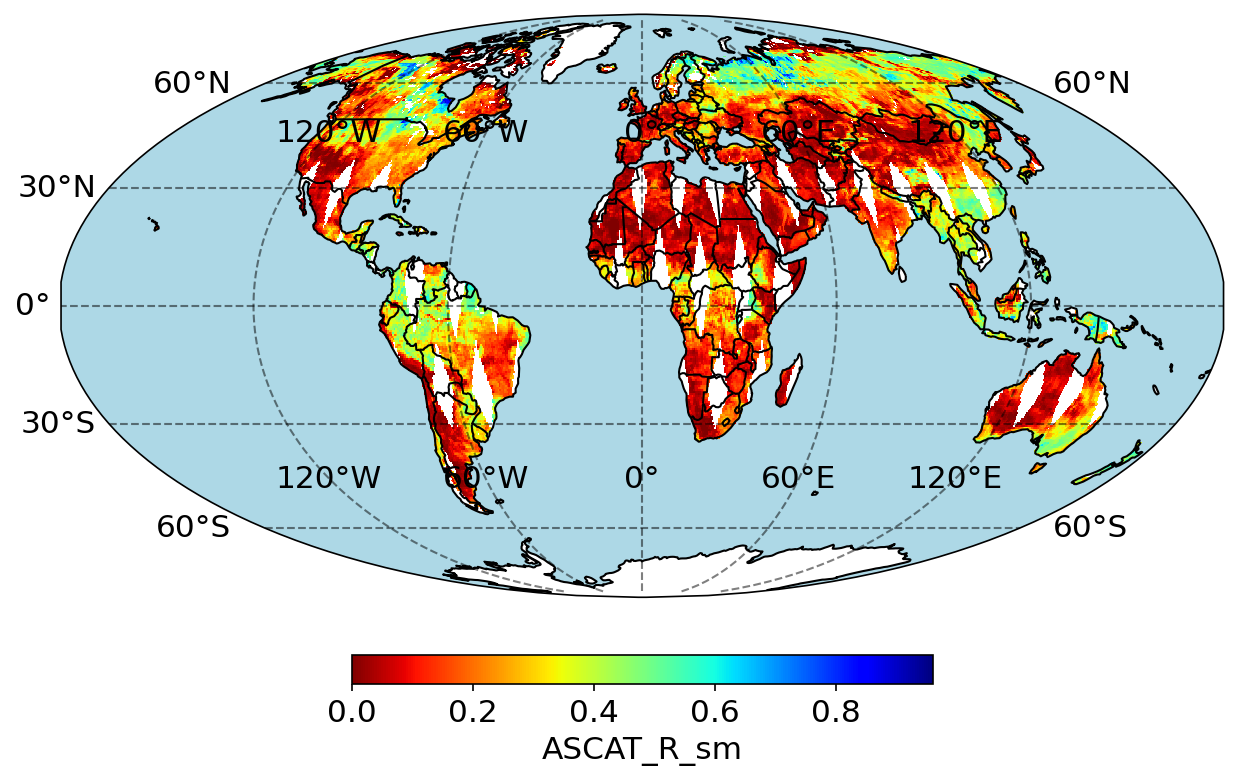

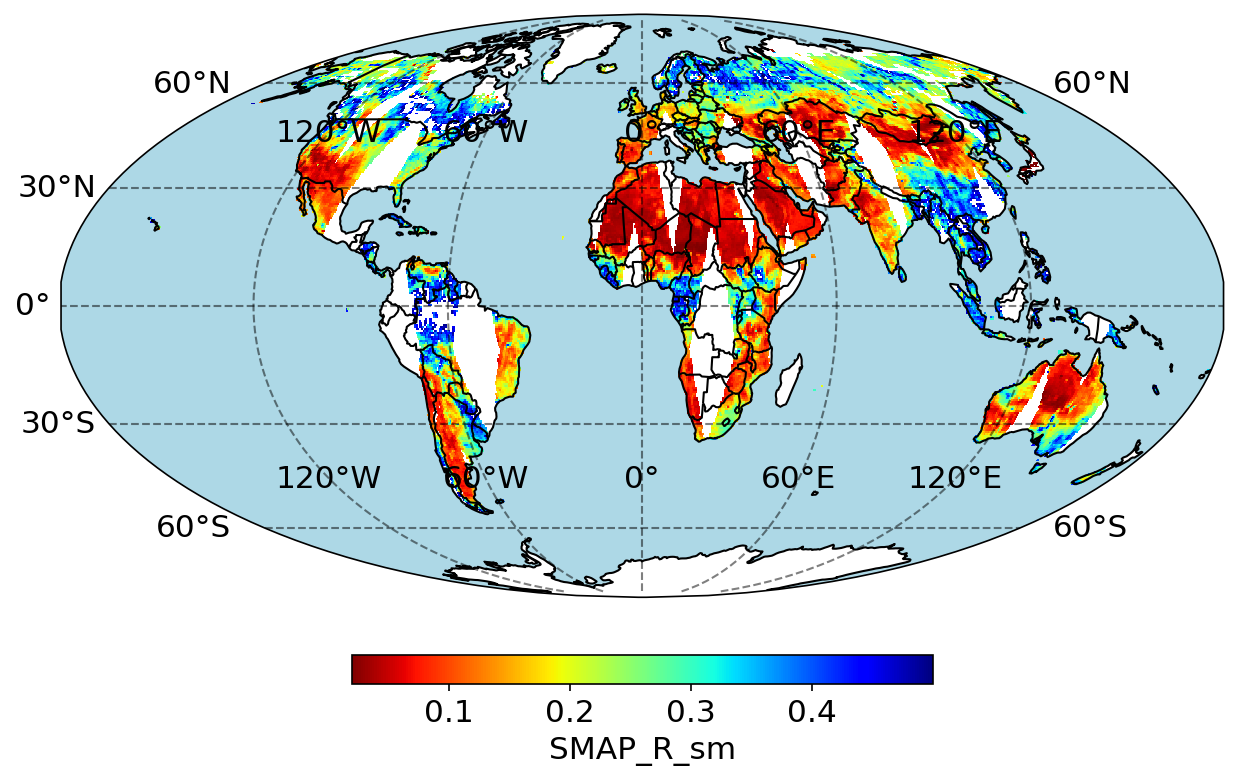

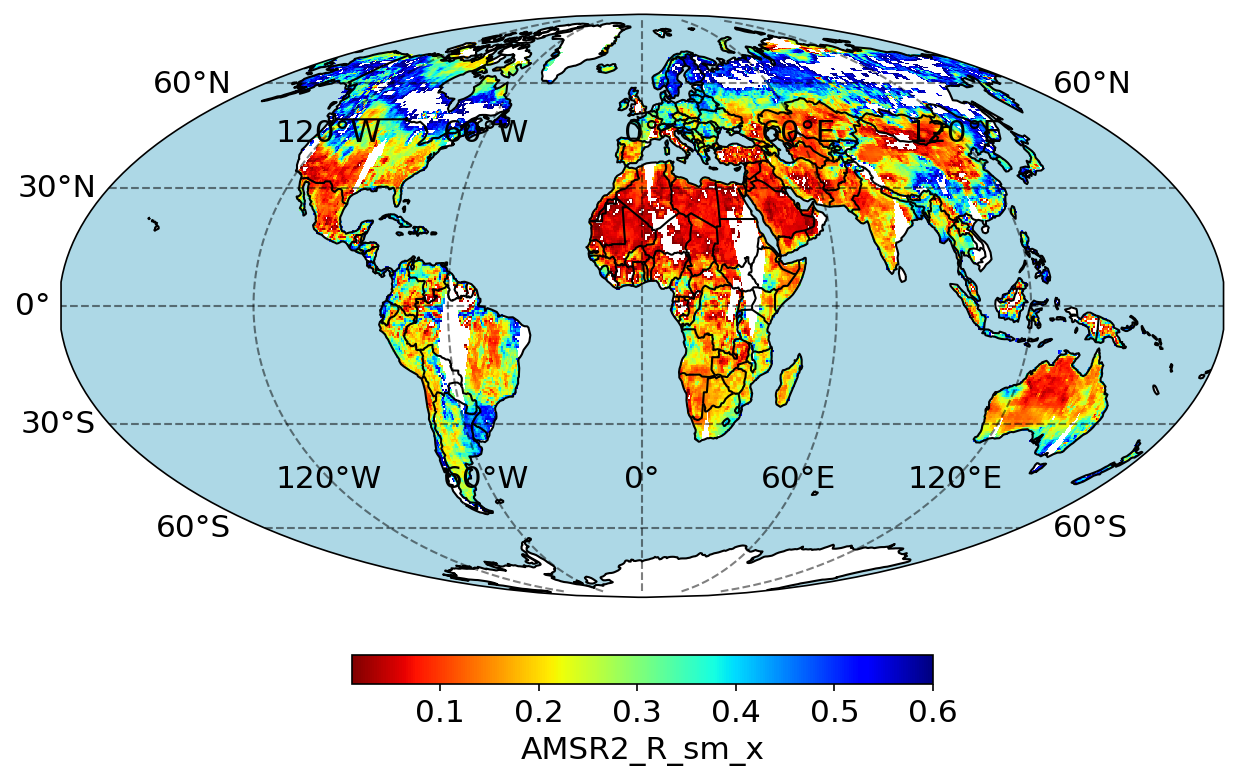

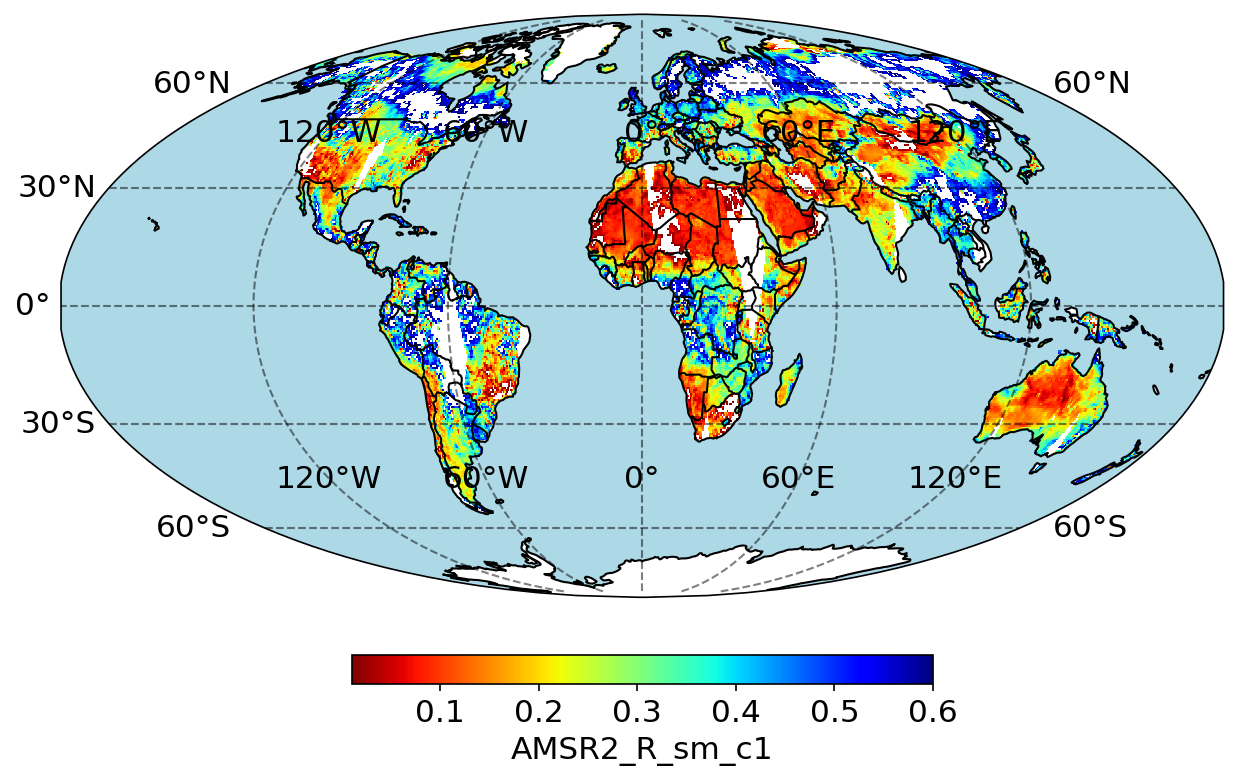

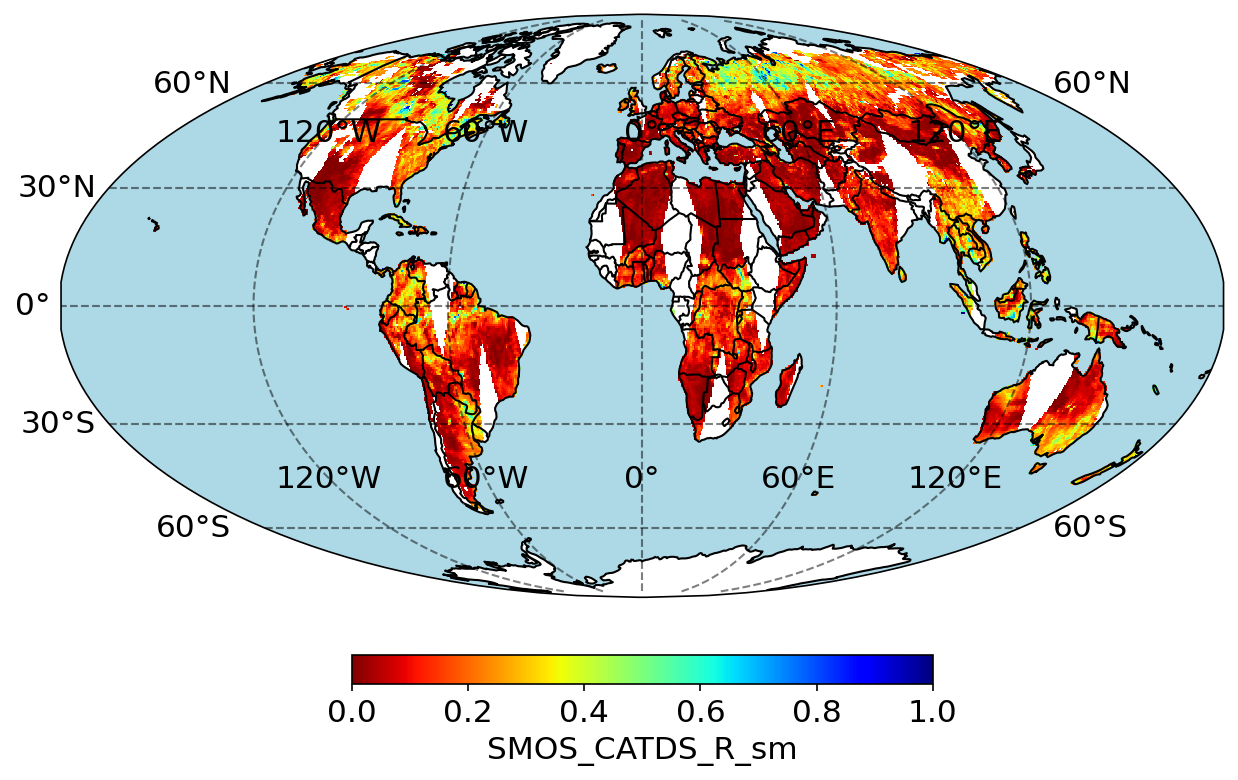

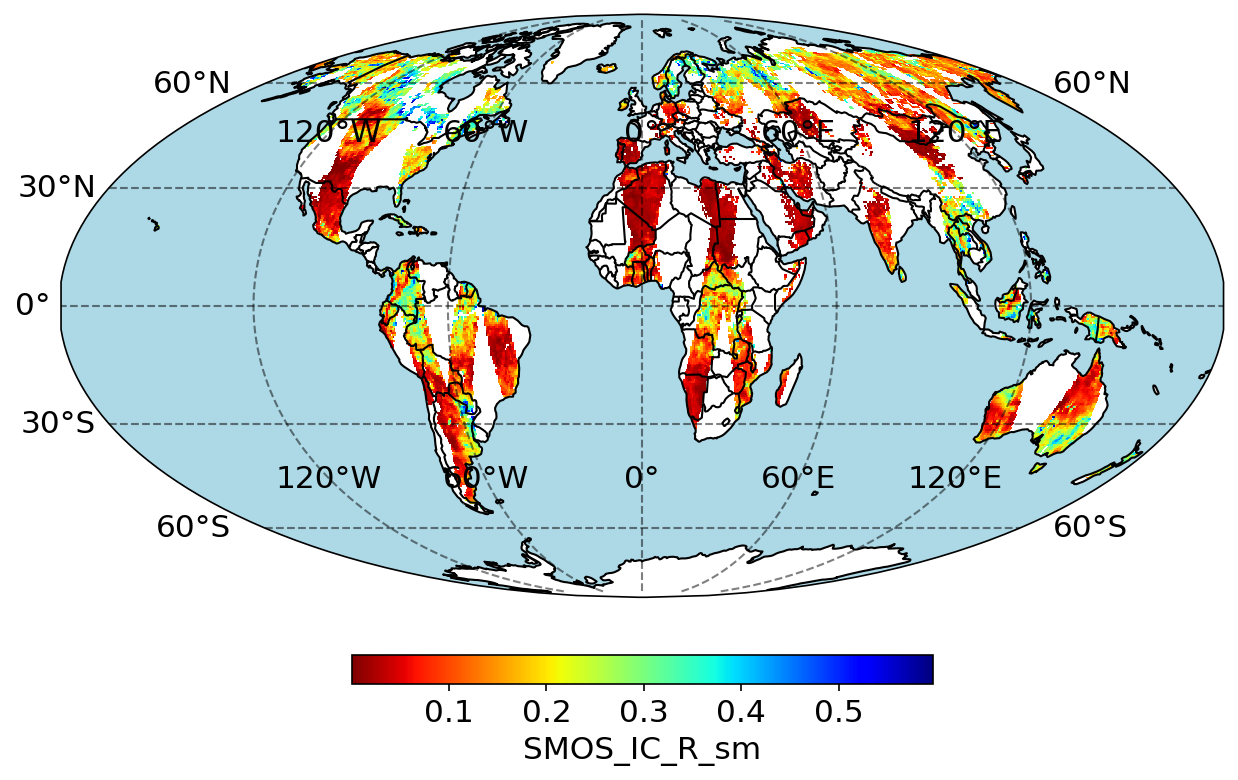

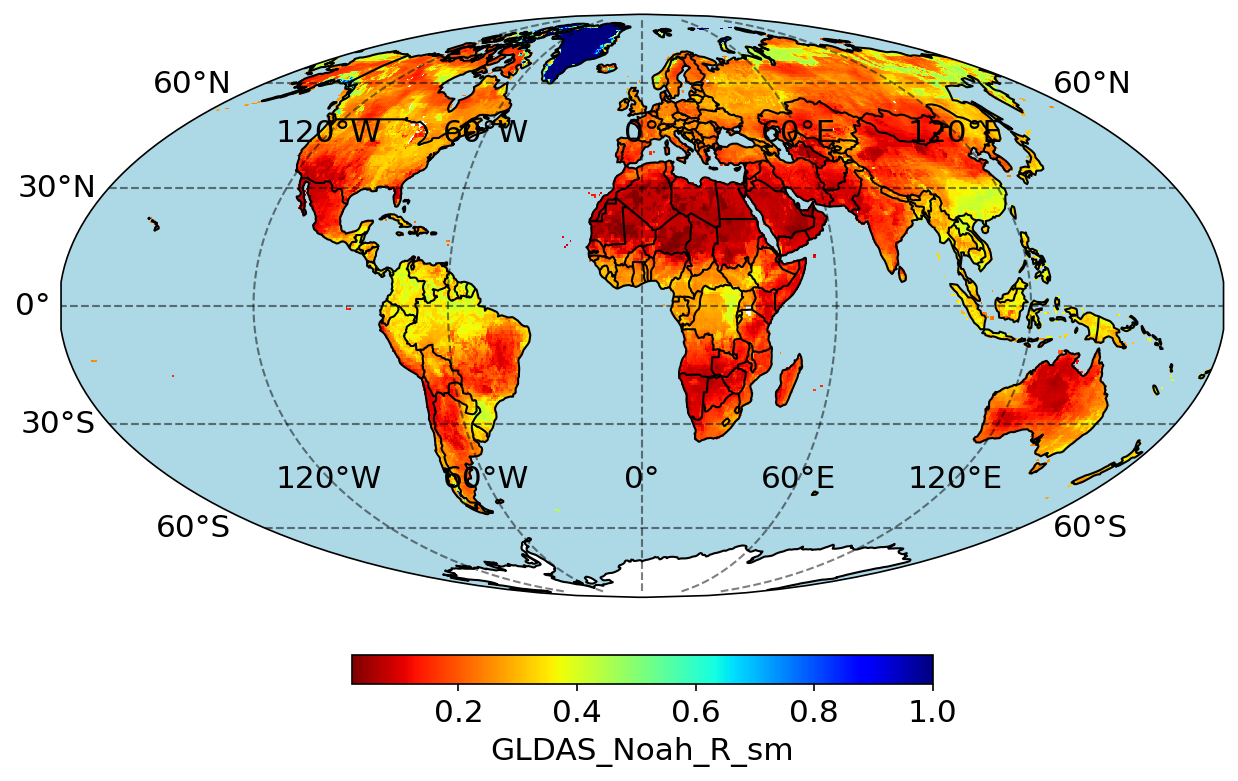

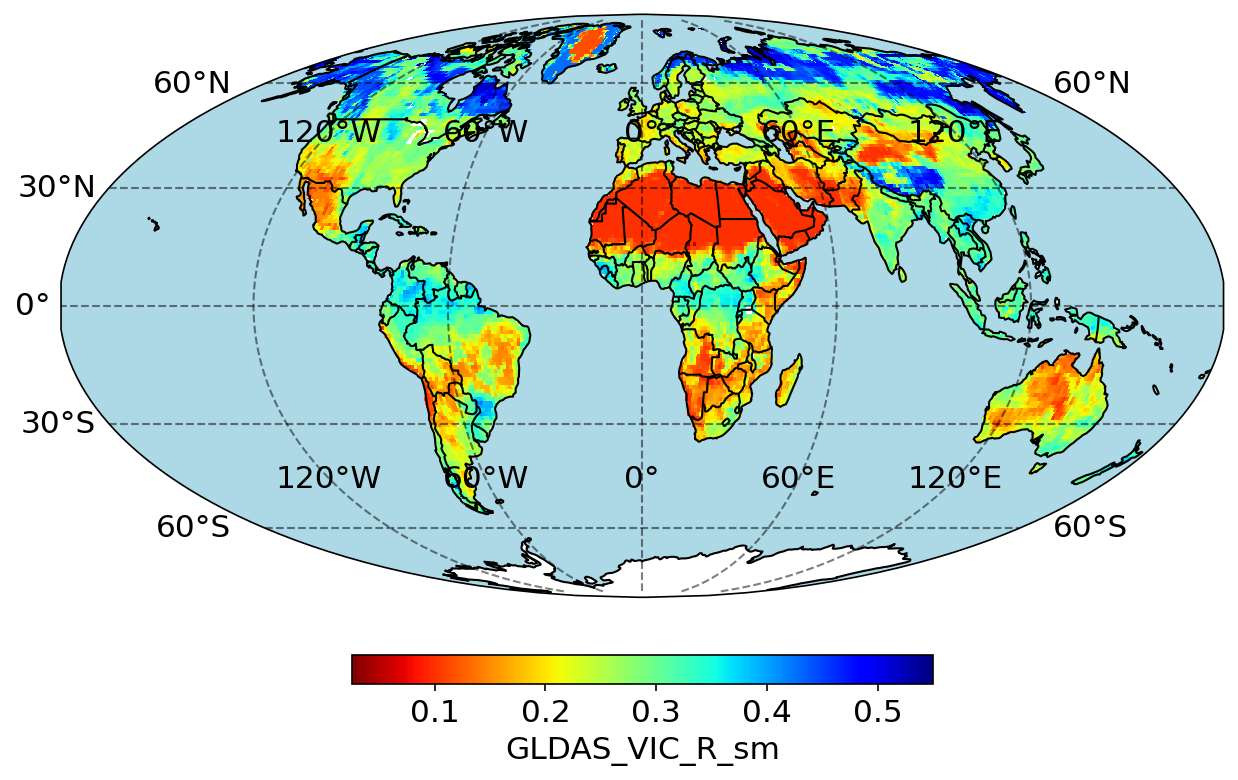

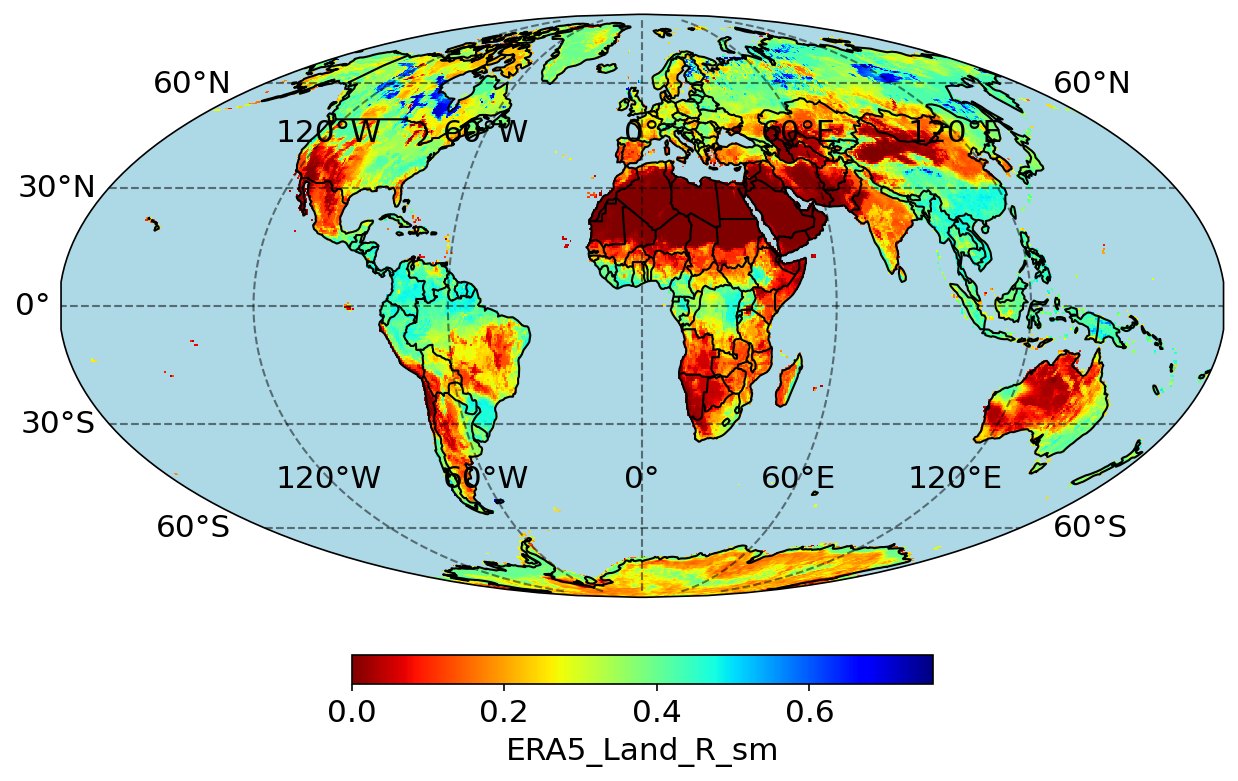

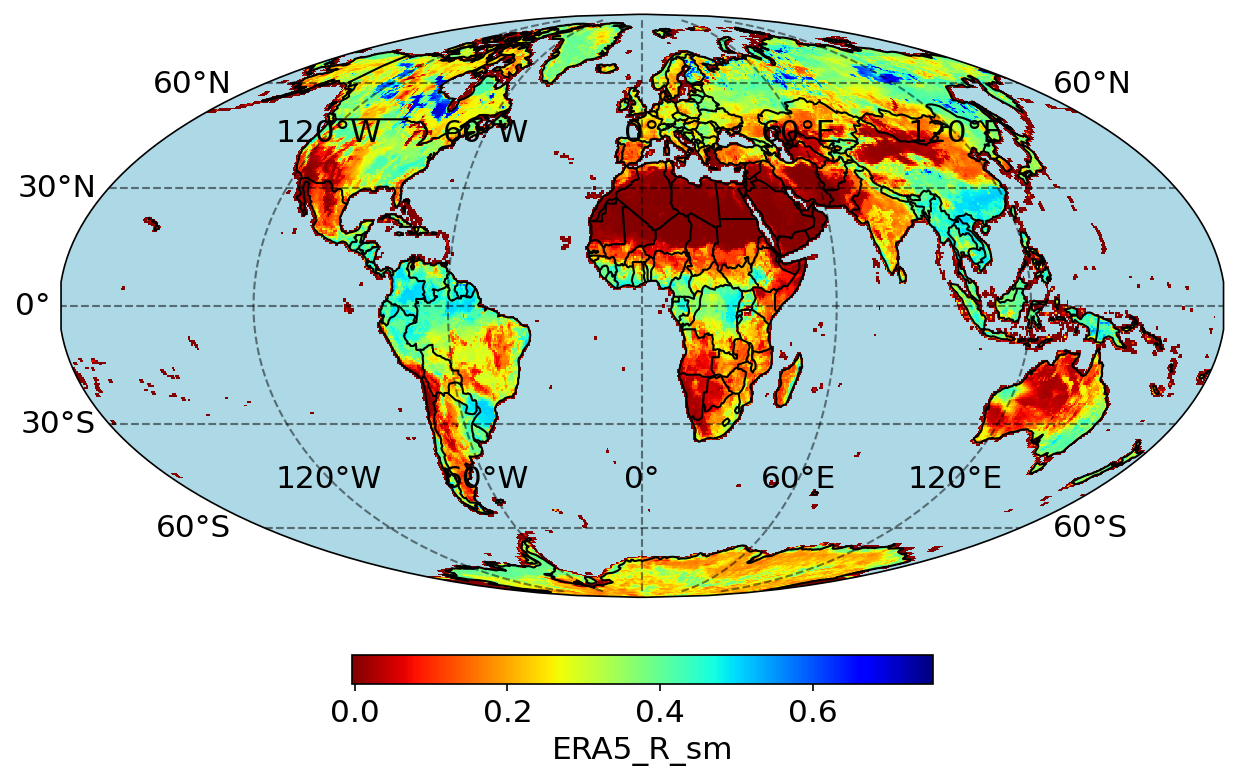

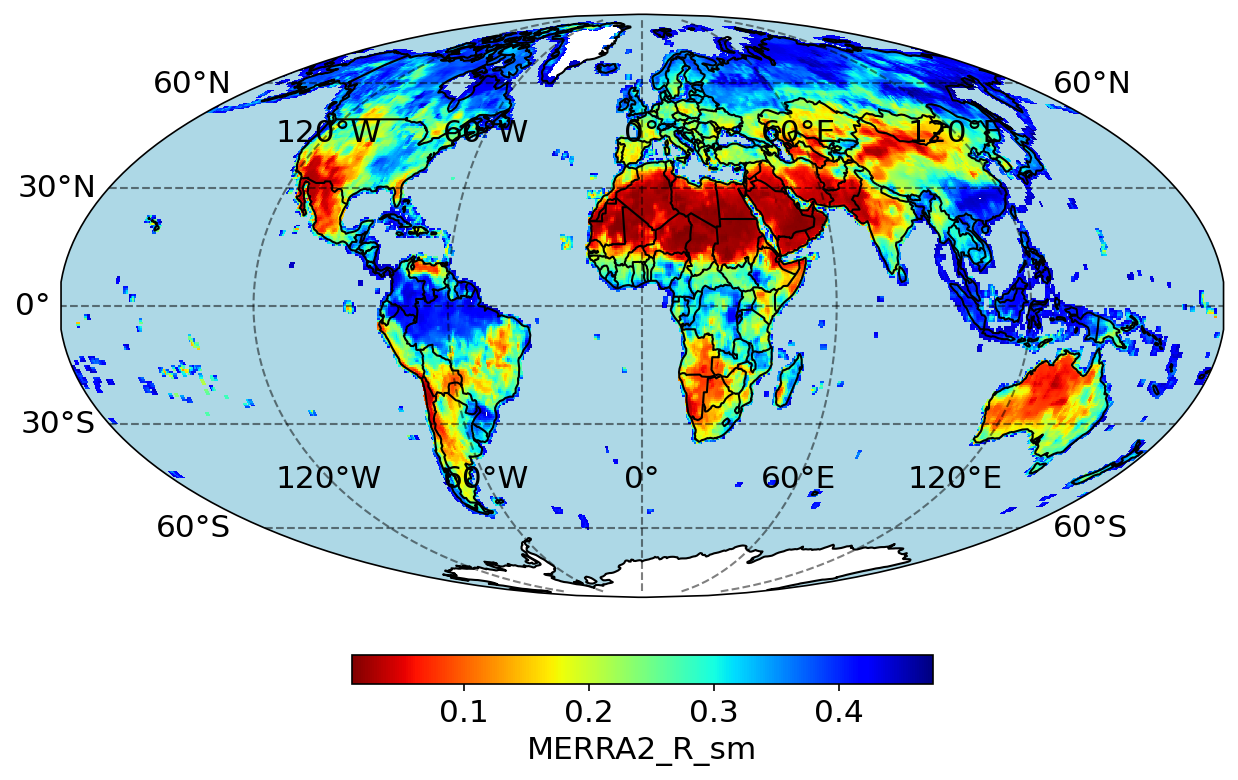

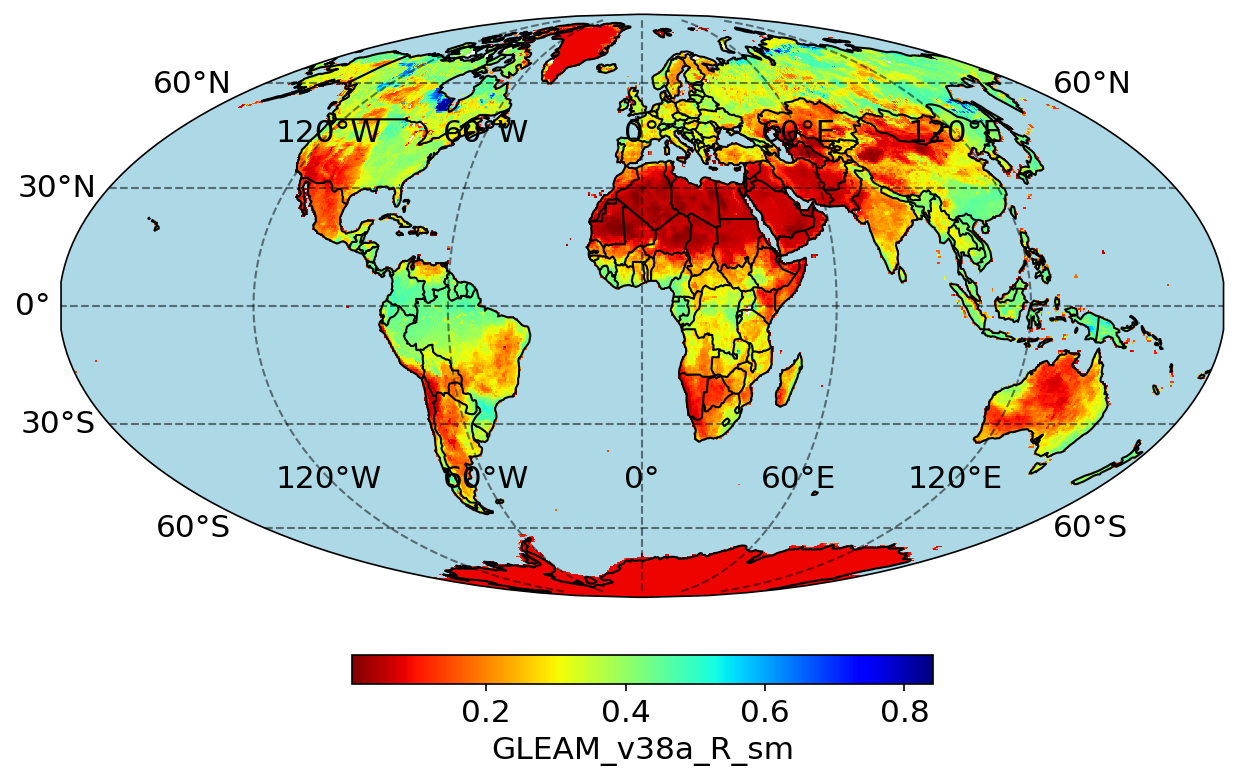

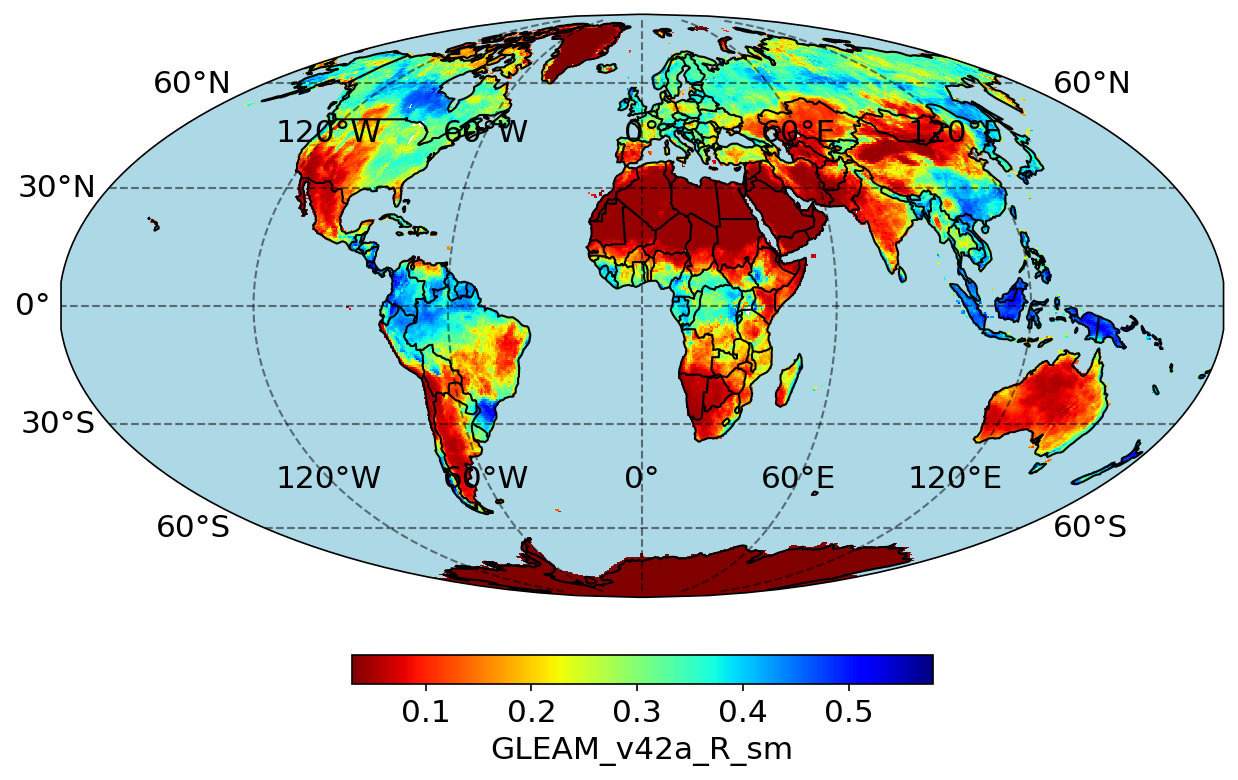


['GLDAS_Noah_R_et', 'GLDAS_VIC_R_et', 'ERA5_R_et', 'MERRA2_R_et', 'GLEAM_v38a_R_et', 'GLEAM_v42a_R_et', 'VISEA_R_et']


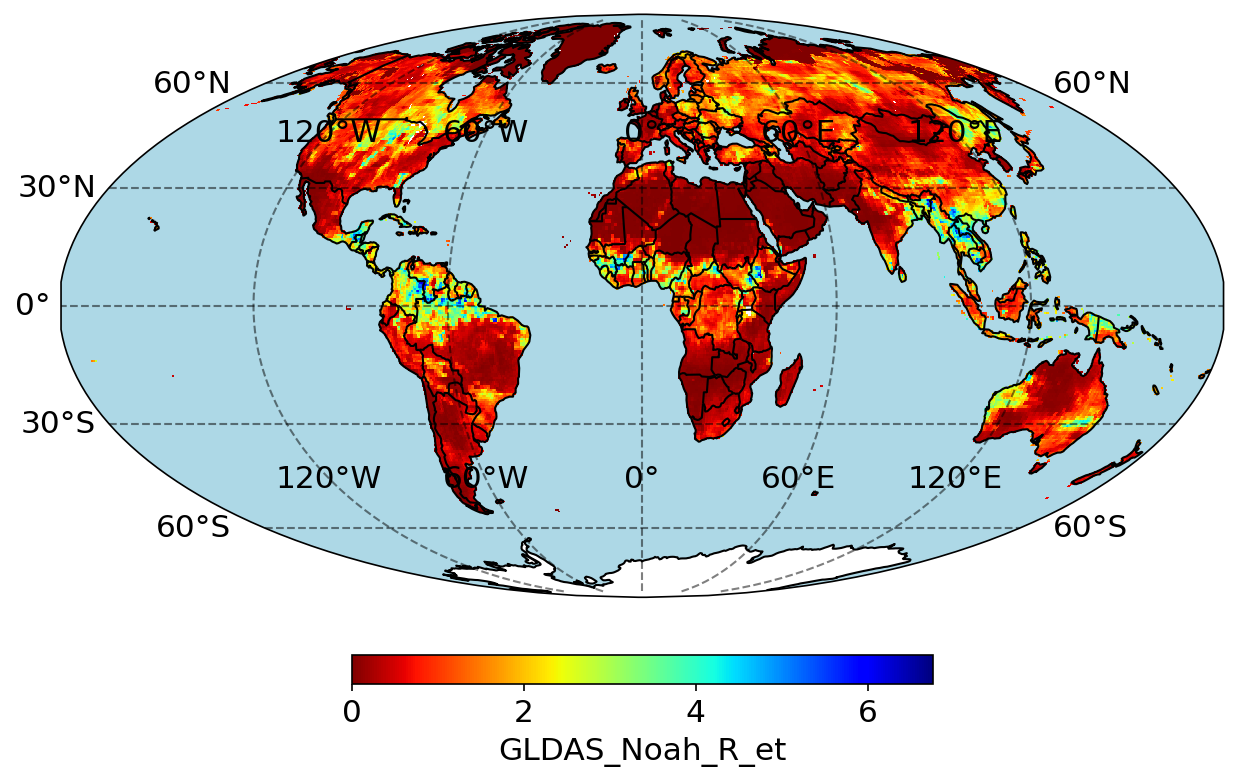

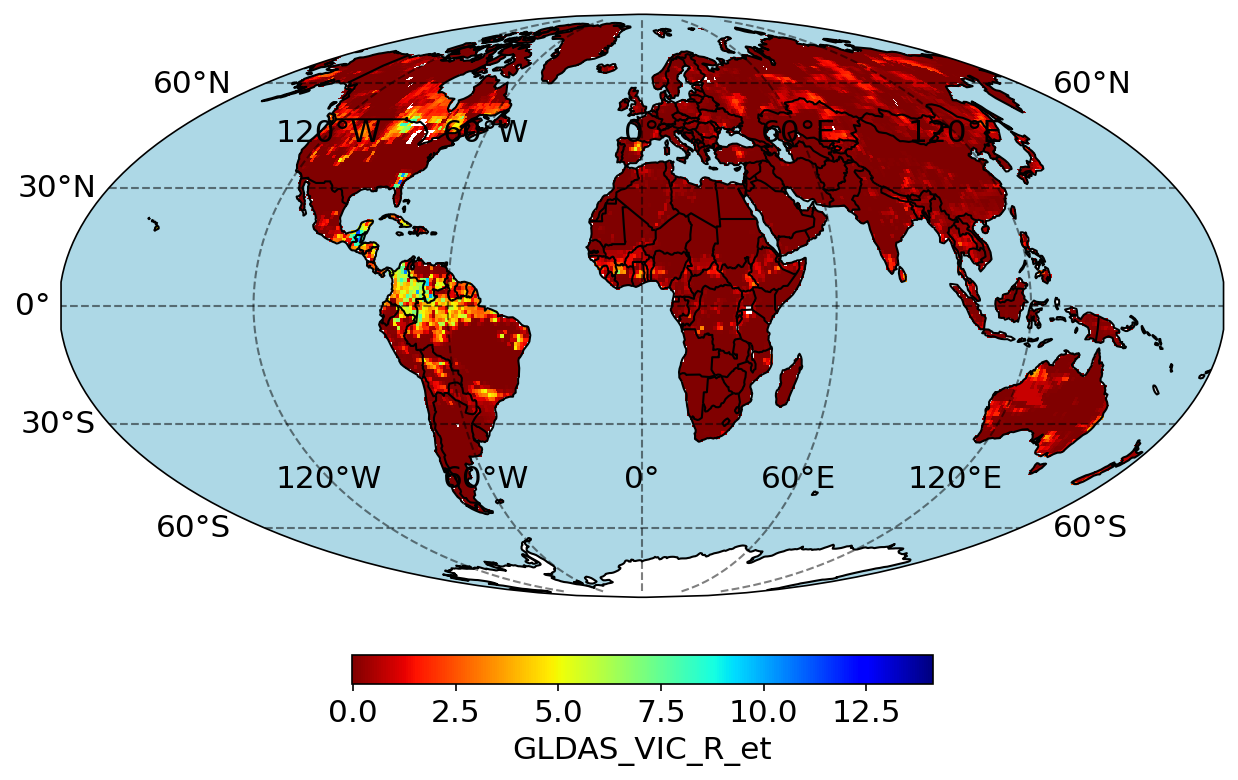

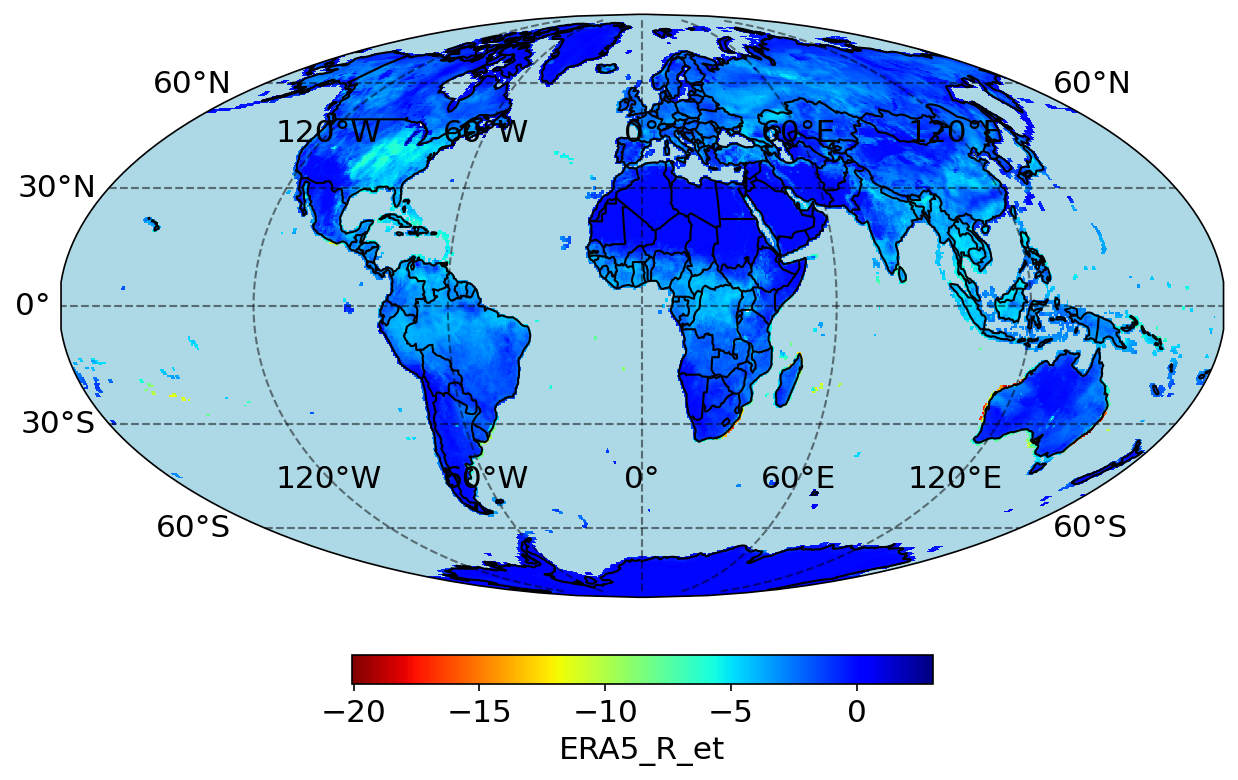

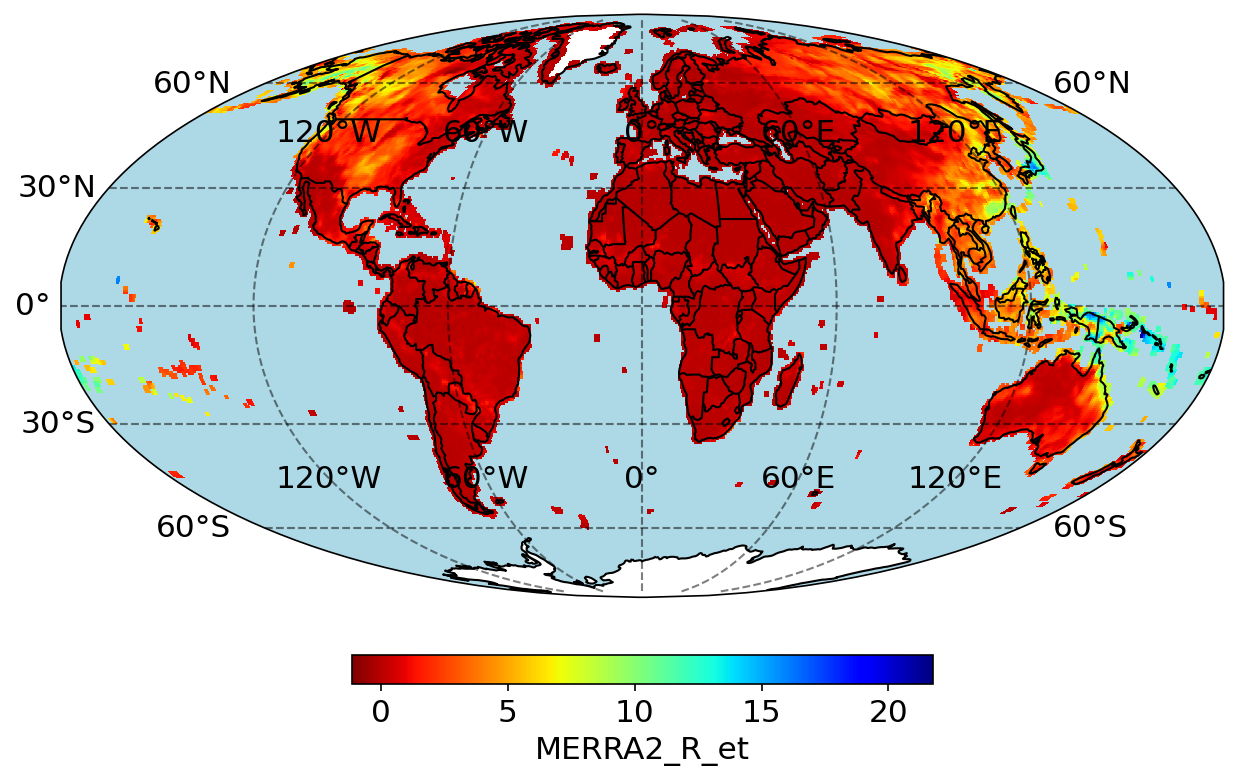

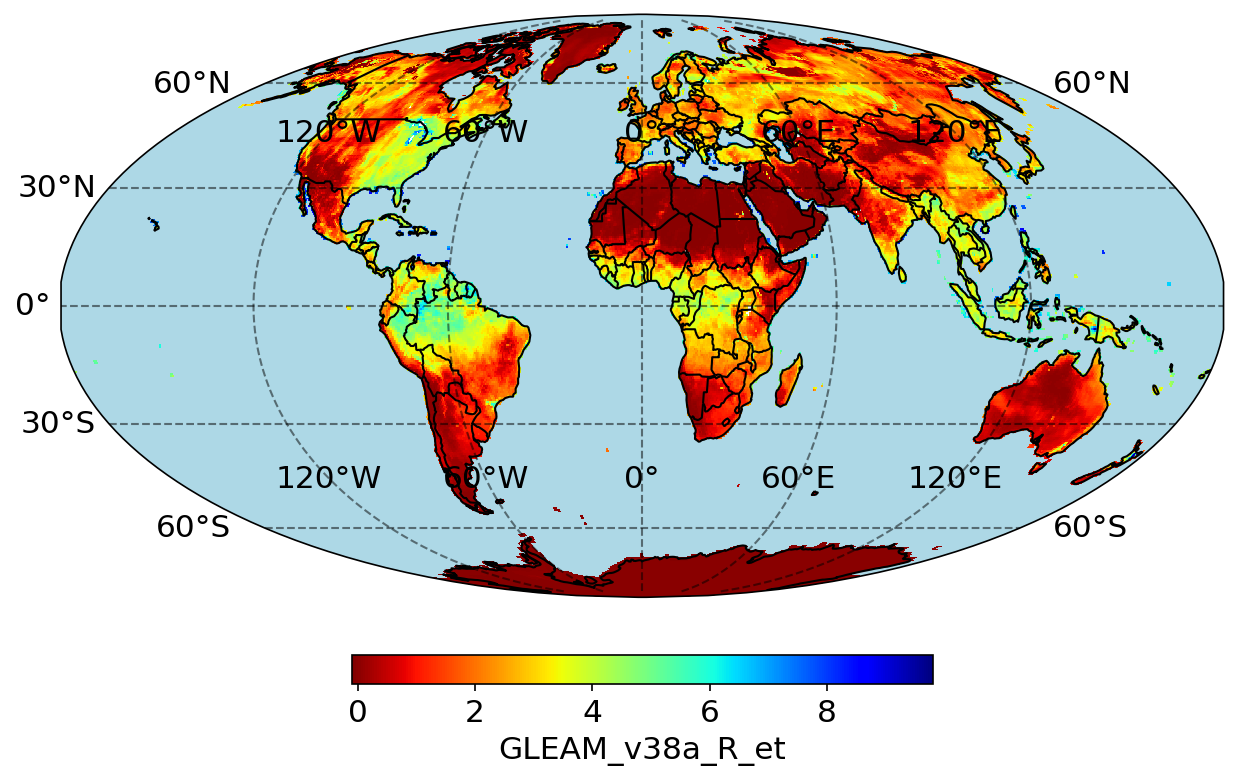

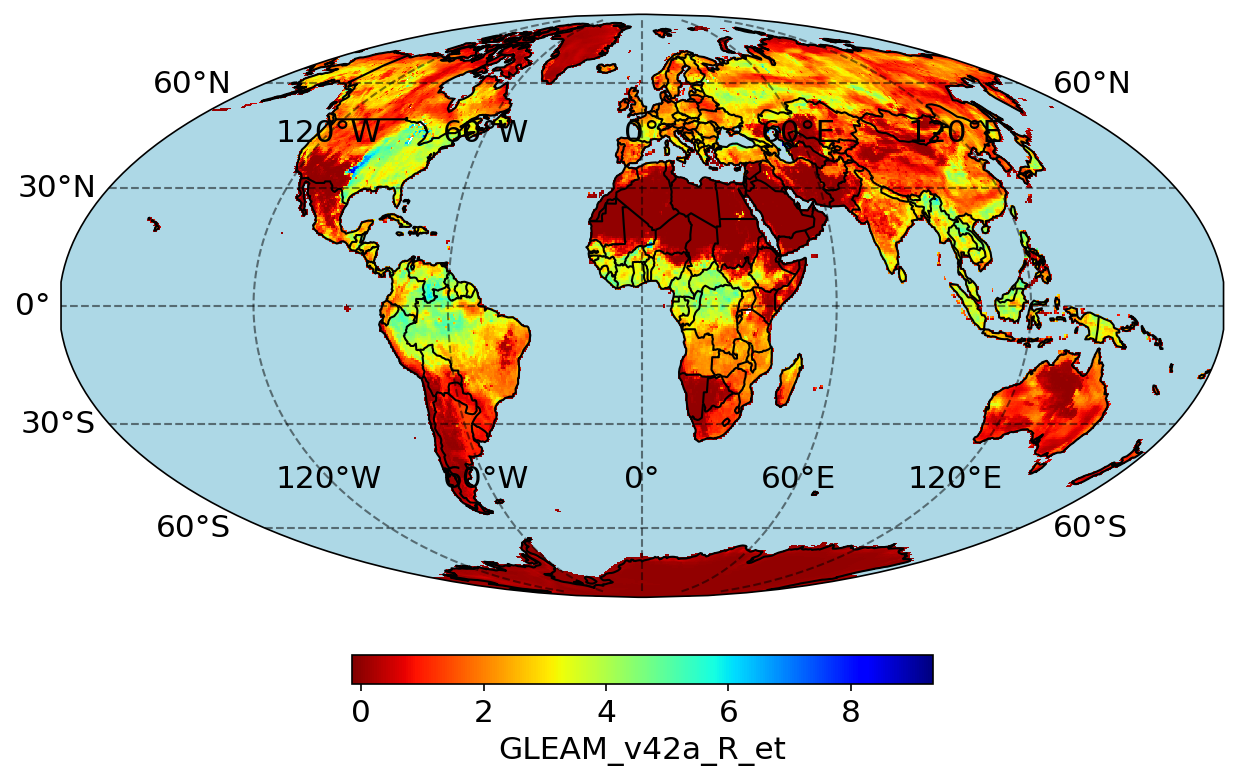

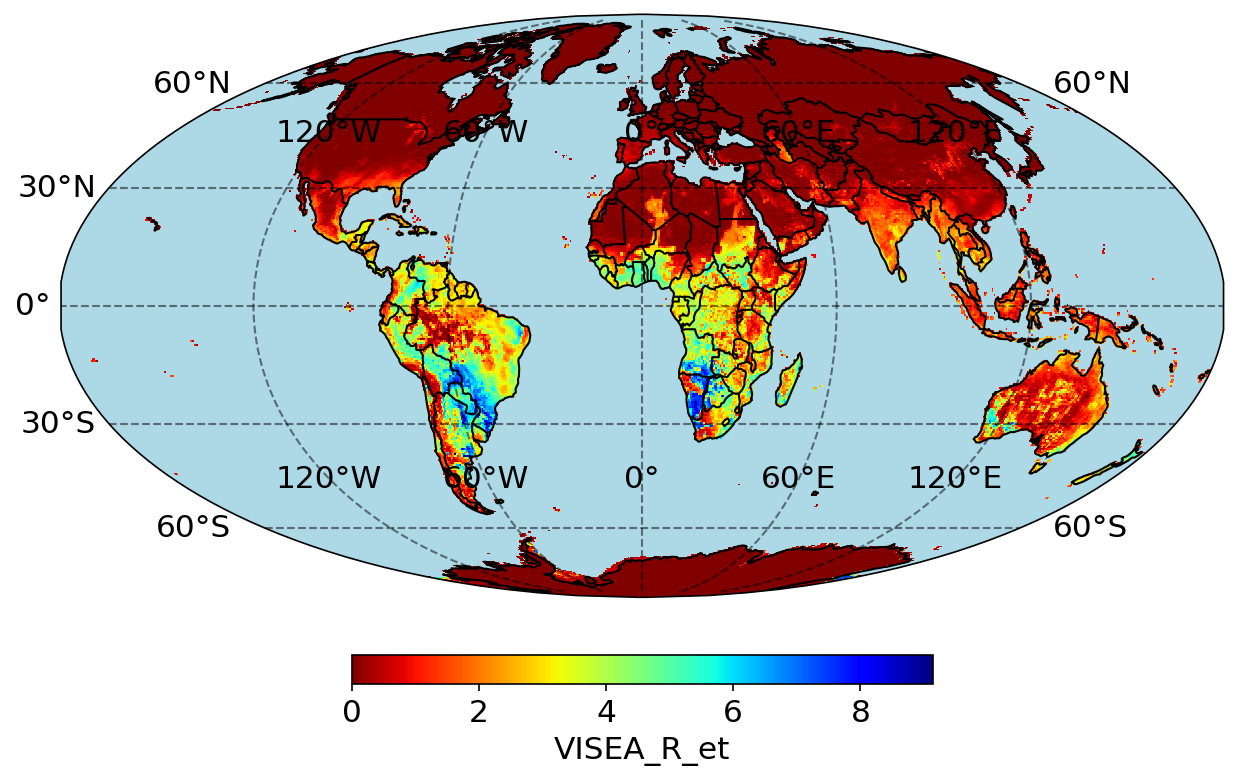

In [18]:
target_year = 2022
target_doy = 150
SM_path = f'{cpuserver_data_FP}/extracted_nc/projects/2025_KMA_050_grid/SM_{target_year}_R_eqd_050.nc'
with netCDF4.Dataset(SM_path) as nc_data:
    SM_var_list = list(nc_data.variables.keys())
    # Remove 'longitude', 'latitude'
    SM_var_list = [var for var in SM_var_list if var not in ['longitude', 'latitude']]
    print(SM_var_list)
    for var in SM_var_list:
        target = nc_data.variables[f'{var}'][:].data[:, :, target_doy]
        hPlot.plot_map(domain_lon, domain_lat, target, np.nanmin(target), np.nanmax(target), plot_title='-', label_title=f'{var}', cmap='jet_r')

print('='*100, '\n')

ET_path = f'{cpuserver_data_FP}/extracted_nc/projects/2025_KMA_050_grid/ET_{target_year}_R_eqd_050.nc'
with netCDF4.Dataset(ET_path) as nc_data:
    ET_var_list = list(nc_data.variables.keys())
    # Remove 'longitude', 'latitude'
    ET_var_list = [var for var in ET_var_list if var not in ['longitude', 'latitude']]
    print(ET_var_list)
    for var in ET_var_list:
        target = nc_data.variables[f'{var}'][:].data[:, :, target_doy]
        hPlot.plot_map(domain_lon, domain_lat, target, np.nanmin(target), np.nanmax(target), plot_title='-', label_title=f'{var}', cmap='jet_r')